# BARRIDO 1

→ El bloque más parecido es el #2 con correlación r = 0.0757


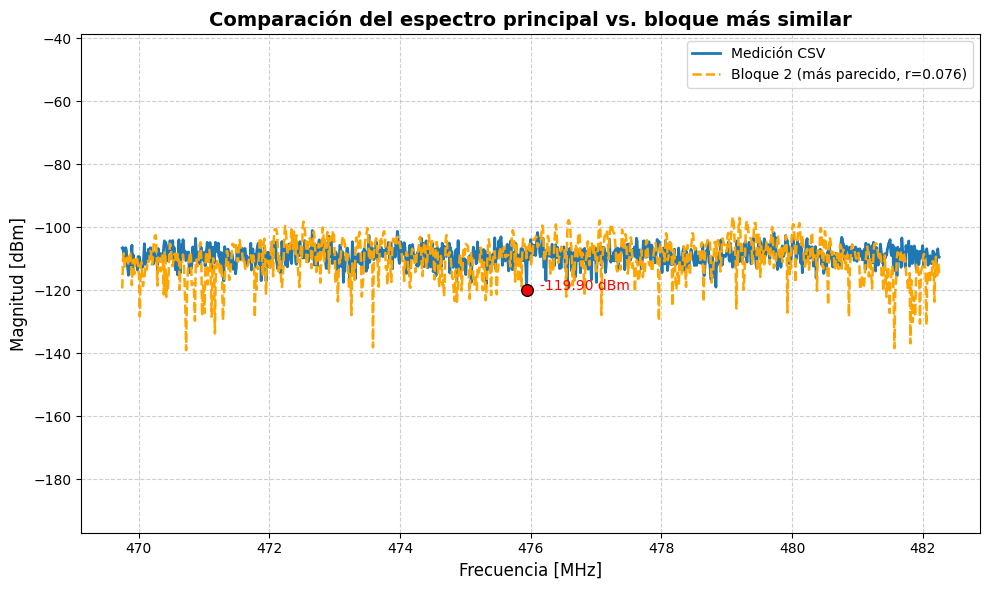

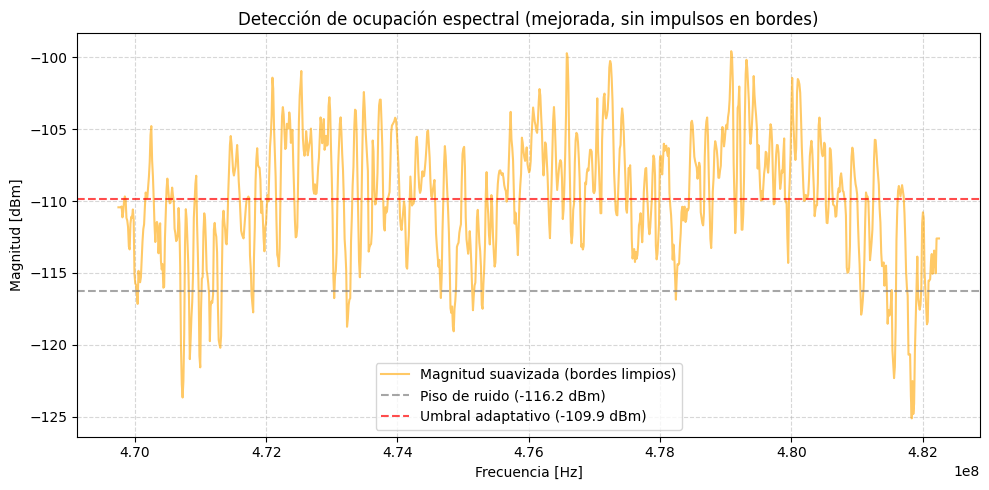


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -116.23 dBm
Desviación estándar del ruido: 2.55 dB
Umbral adaptativo: -109.86 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/476barrido1.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/476M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 4
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")



# BARRIDO 2


→ El bloque más parecido es el #1 con correlación r = 0.1538


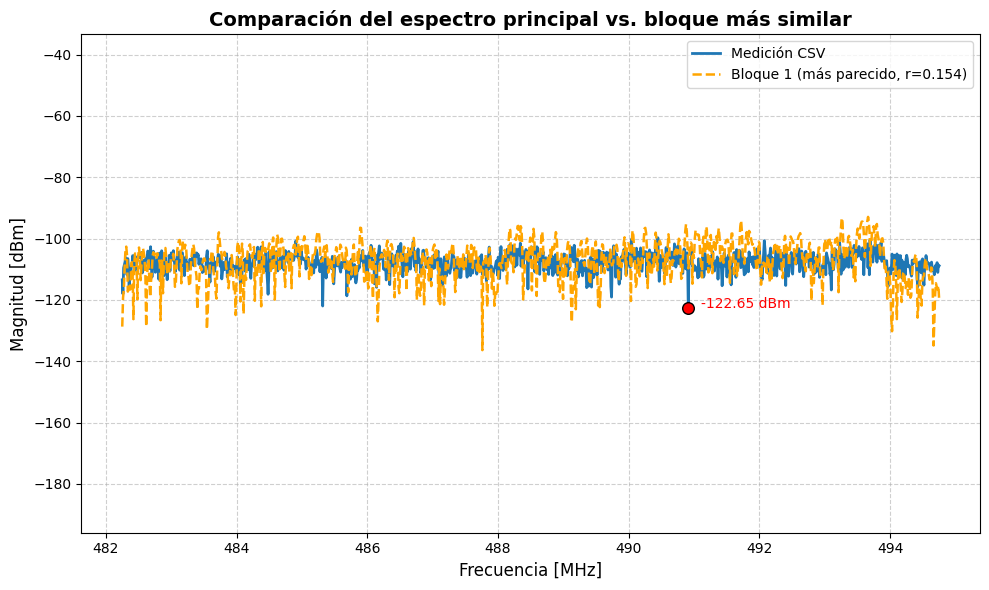

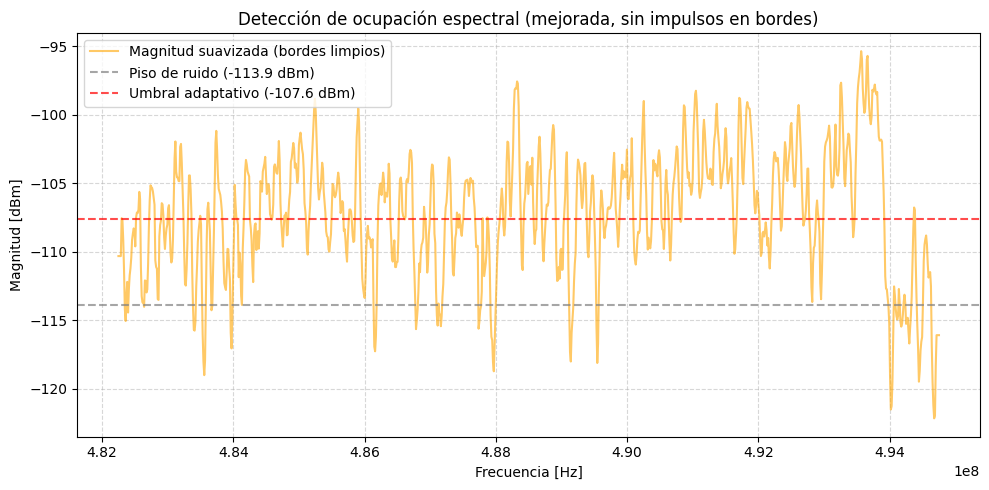


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -113.88 dBm
Desviación estándar del ruido: 2.51 dB
Umbral adaptativo: -107.61 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/488barrido2.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/488_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 3


→ El bloque más parecido es el #2 con correlación r = 0.0531


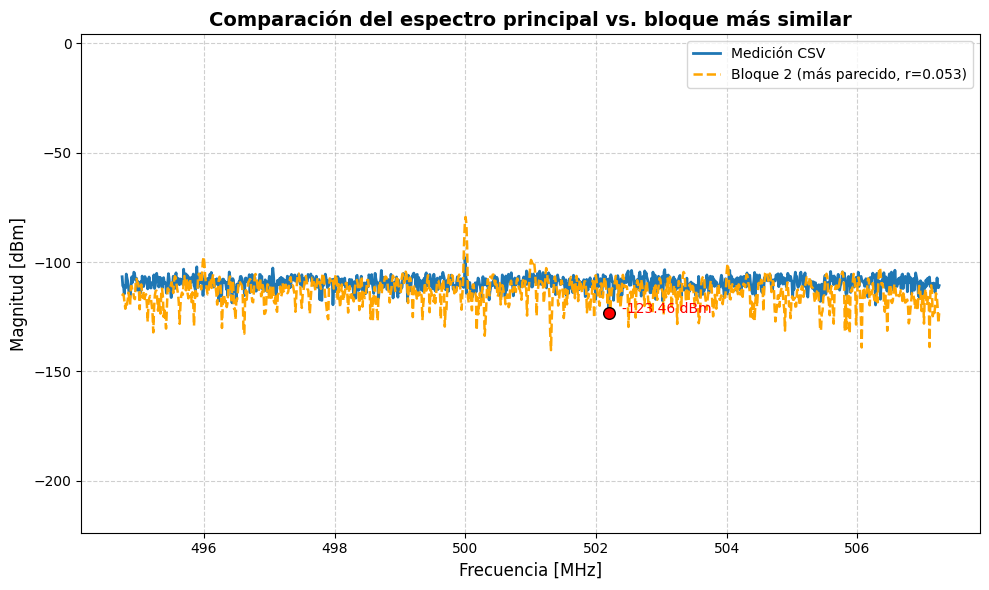

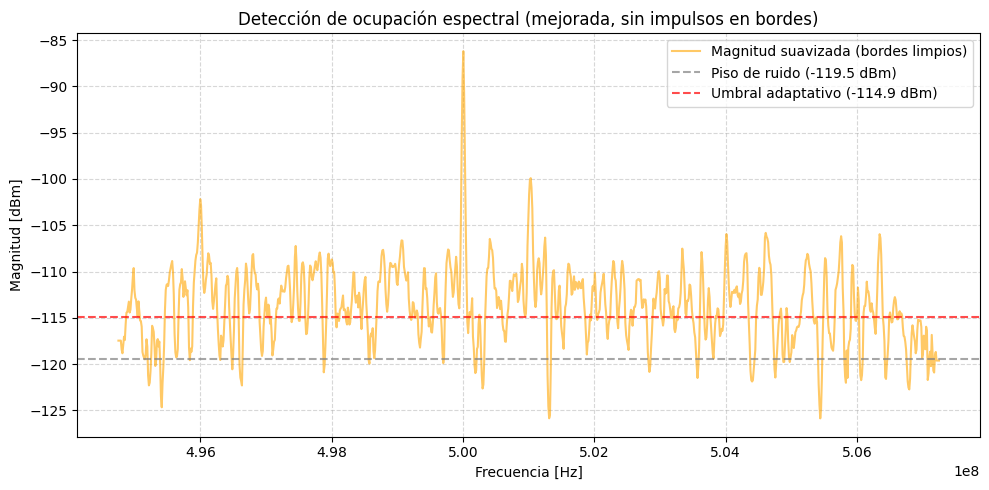


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -119.47 dBm
Desviación estándar del ruido: 1.81 dB
Umbral adaptativo: -114.94 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/501barrido3.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/501M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")



# BARRIDO 4


→ El bloque más parecido es el #1 con correlación r = 0.0399


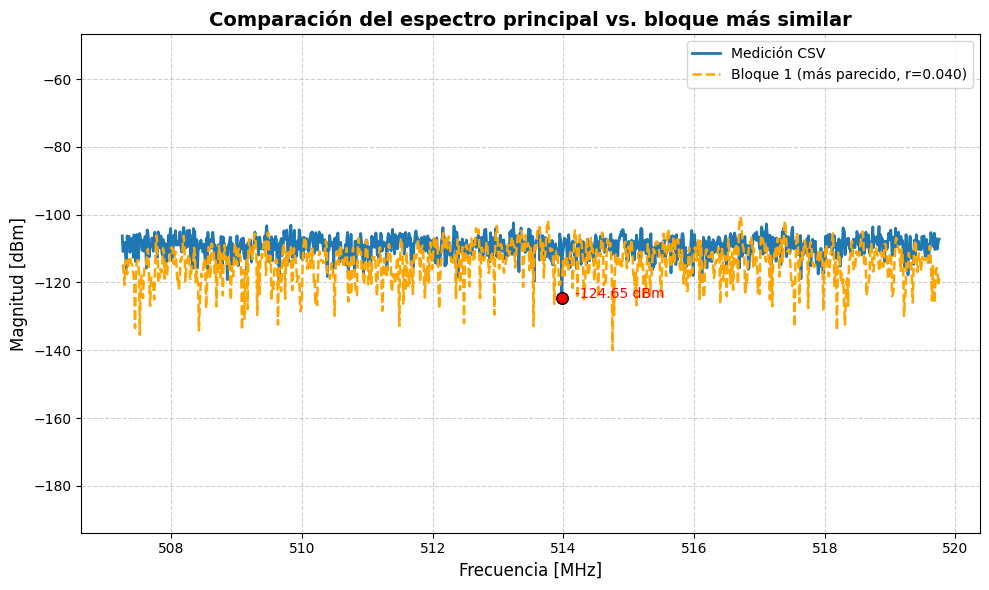

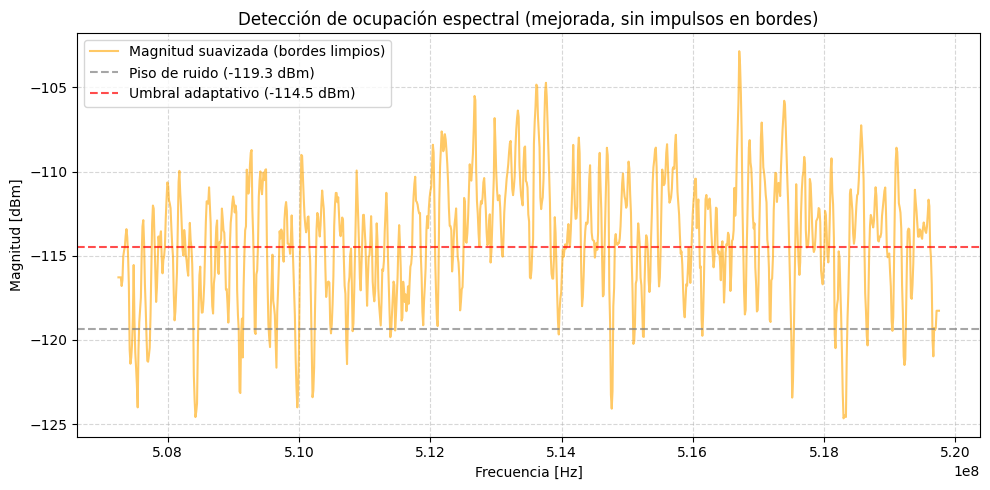


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -119.33 dBm
Desviación estándar del ruido: 1.94 dB
Umbral adaptativo: -114.48 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/513barrido4.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/513_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")



# BARRIDO 5


→ El bloque más parecido es el #1 con correlación r = -0.0049


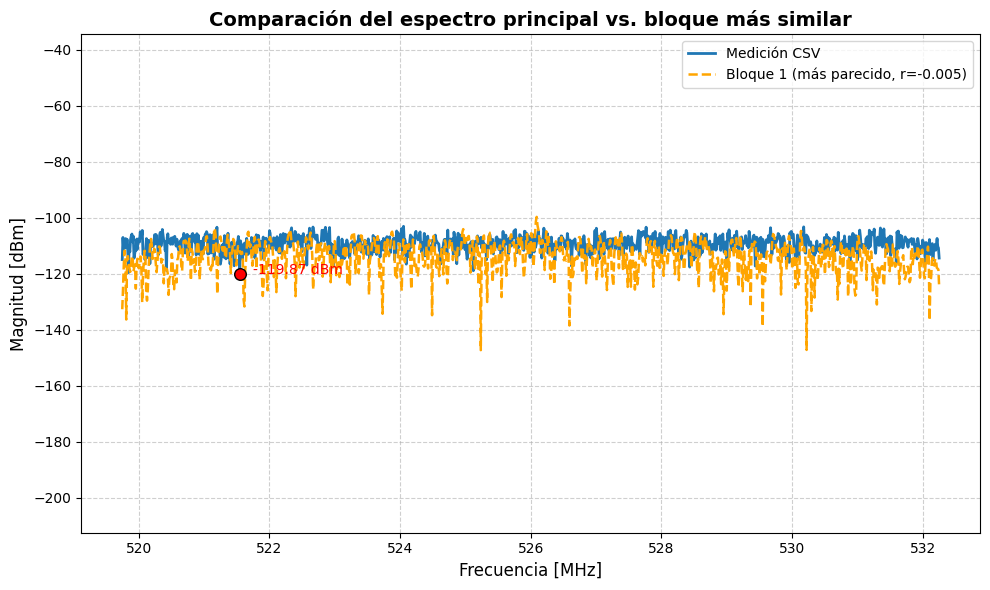

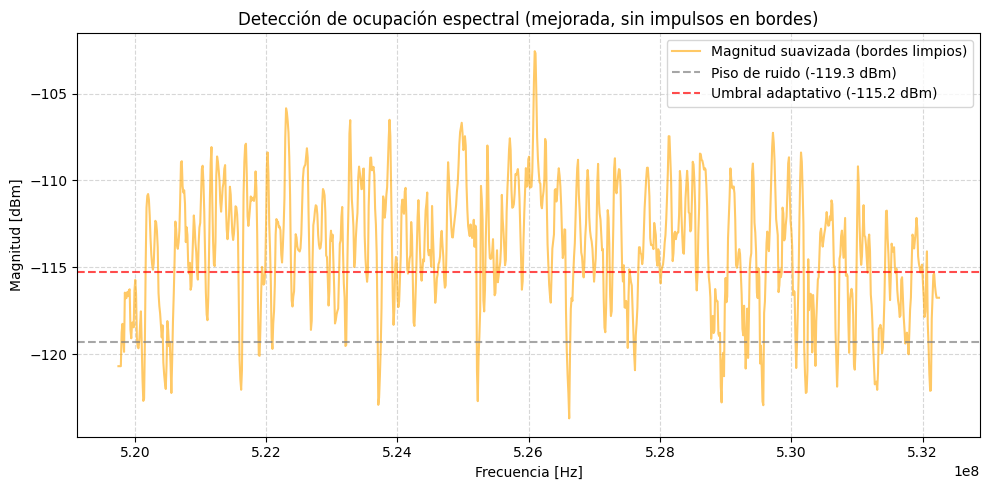


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -119.27 dBm
Desviación estándar del ruido: 1.61 dB
Umbral adaptativo: -115.24 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/526barrido5.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/526M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 3
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 6


→ El bloque más parecido es el #2 con correlación r = 0.0025


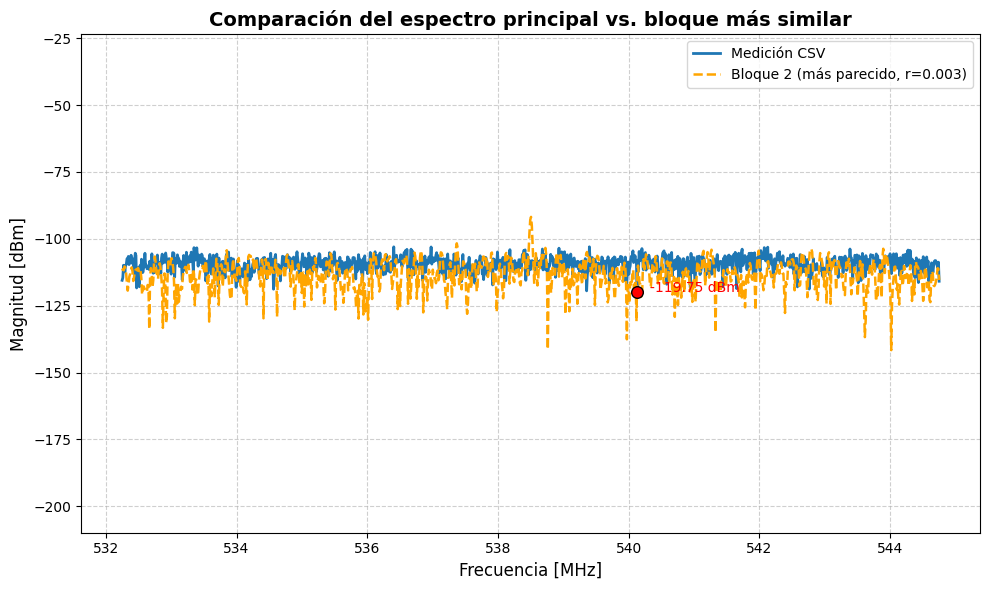

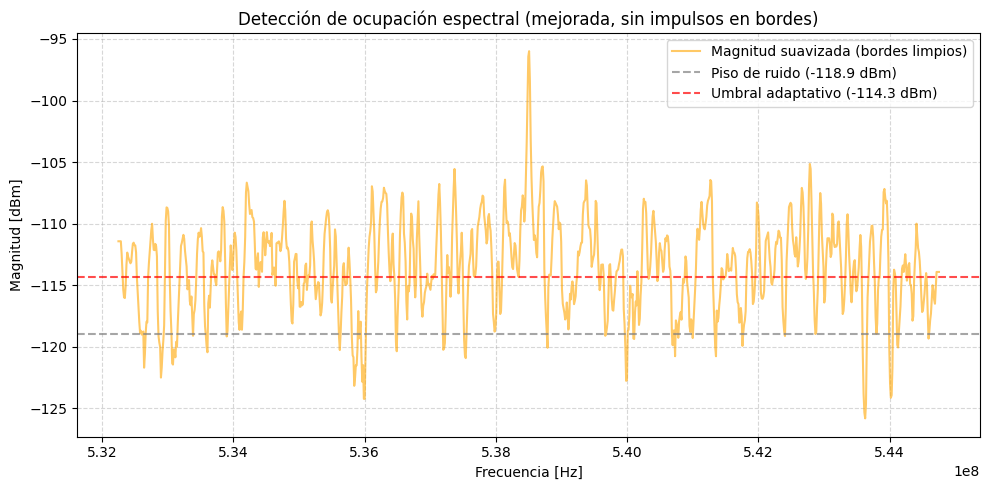


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -118.94 dBm
Desviación estándar del ruido: 1.85 dB
Umbral adaptativo: -114.31 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/538barrido6.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/538_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 7


→ El bloque más parecido es el #2 con correlación r = 0.2352


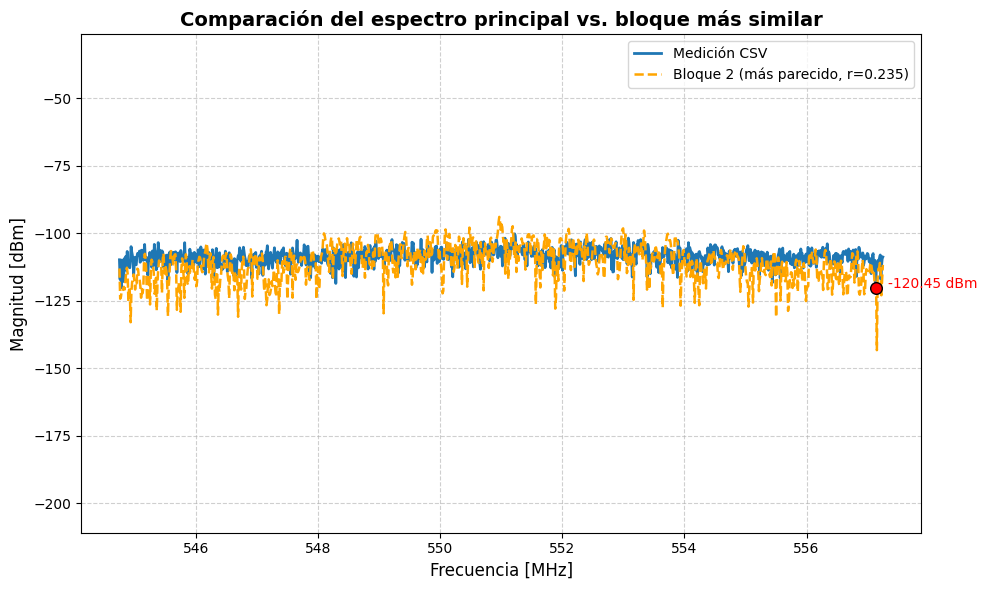

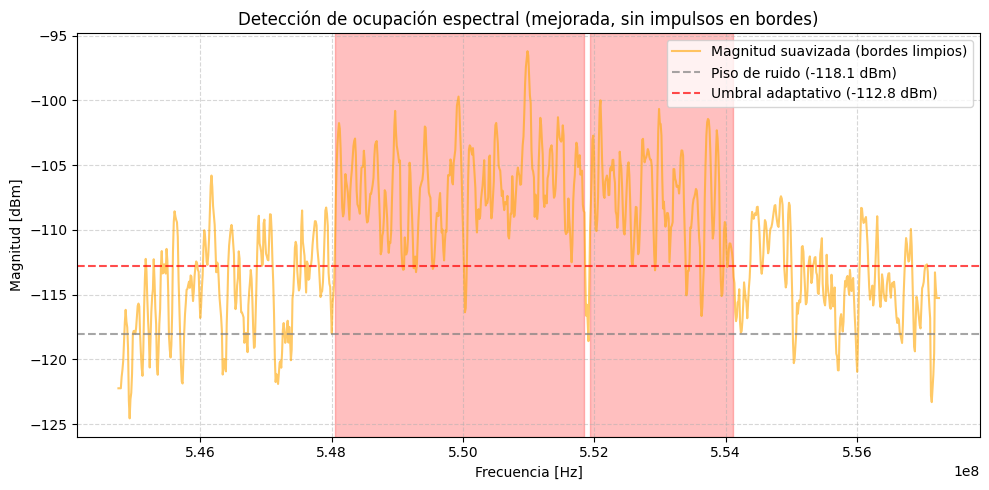


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -118.06 dBm
Desviación estándar del ruido: 2.10 dB
Umbral adaptativo: -112.80 dBm

Se detectaron 2 canales ocupados:
  Canal 1: 548.05 – 551.85 MHz
  Canal 2: 551.93 – 554.11 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/551barrido7.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/551M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 8


→ El bloque más parecido es el #1 con correlación r = 0.0073


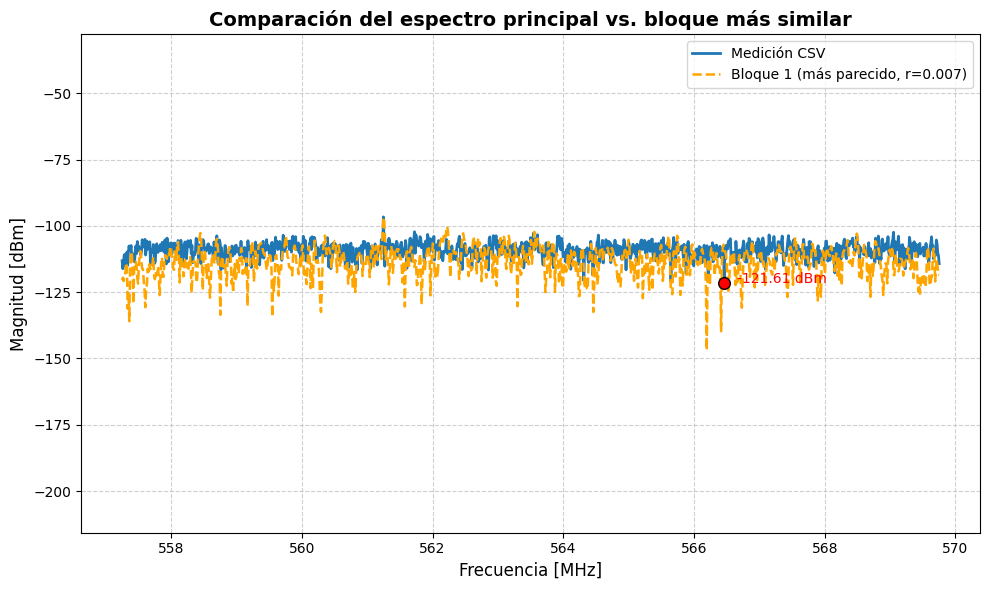

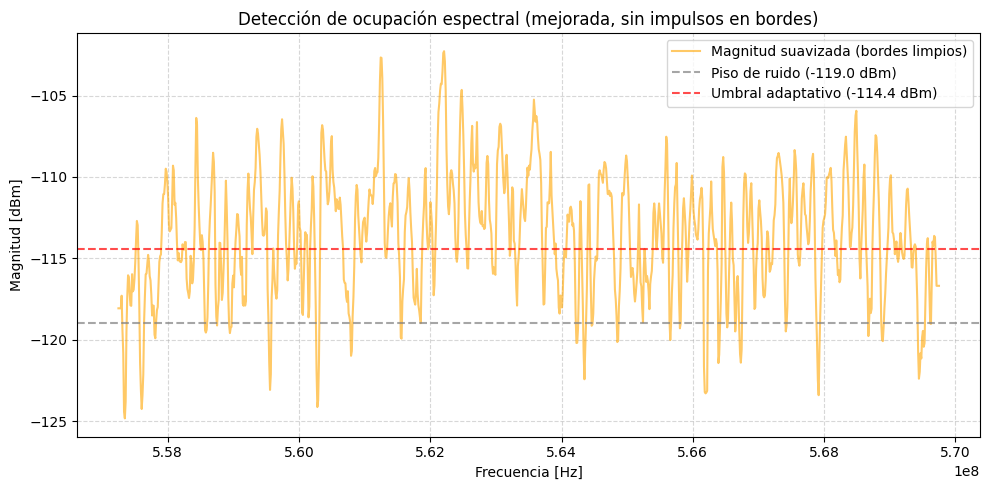


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -119.00 dBm
Desviación estándar del ruido: 1.84 dB
Umbral adaptativo: -114.40 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/563barrido8.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/563_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 4     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 9


→ El bloque más parecido es el #2 con correlación r = 0.0159


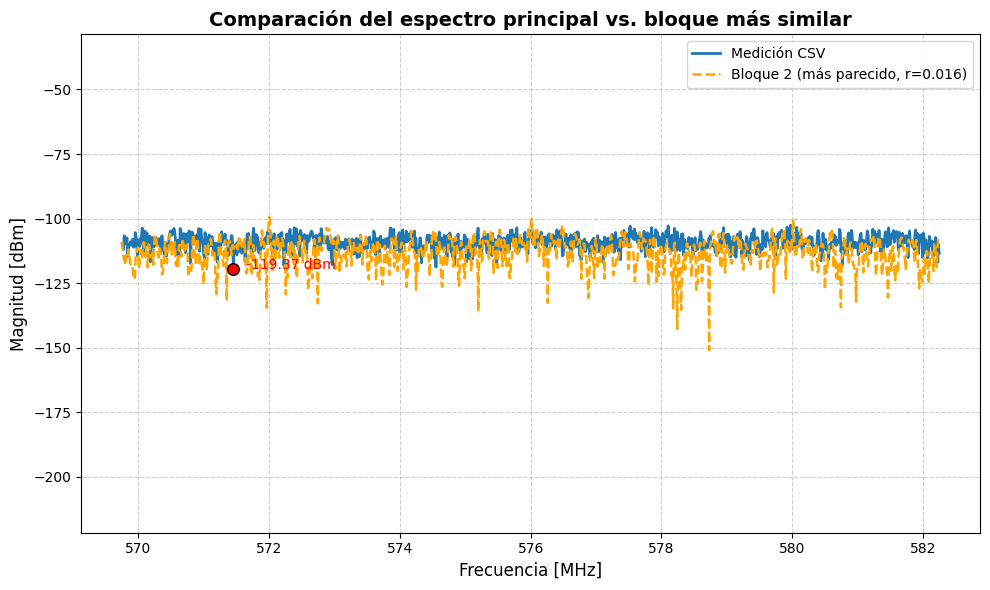

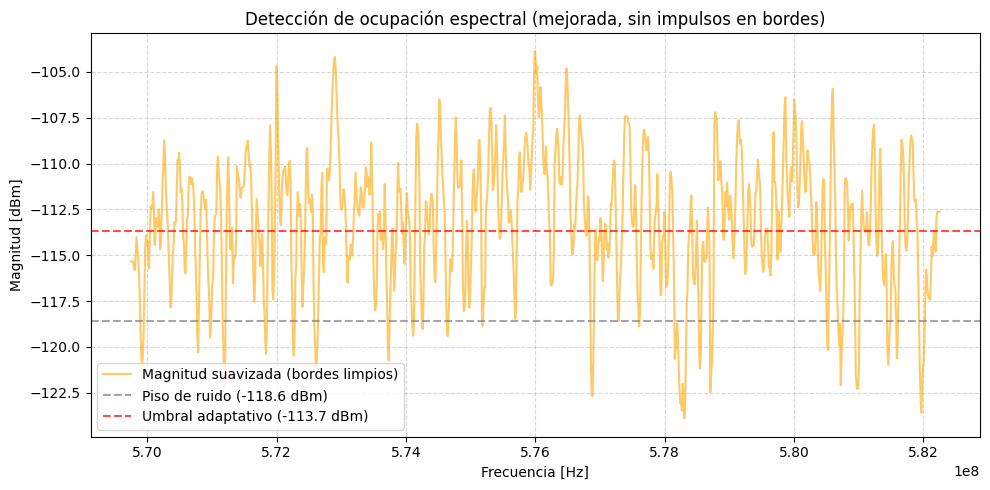


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -118.62 dBm
Desviación estándar del ruido: 1.98 dB
Umbral adaptativo: -113.67 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/576barrido9.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/576M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 10


→ El bloque más parecido es el #1 con correlación r = 0.0355


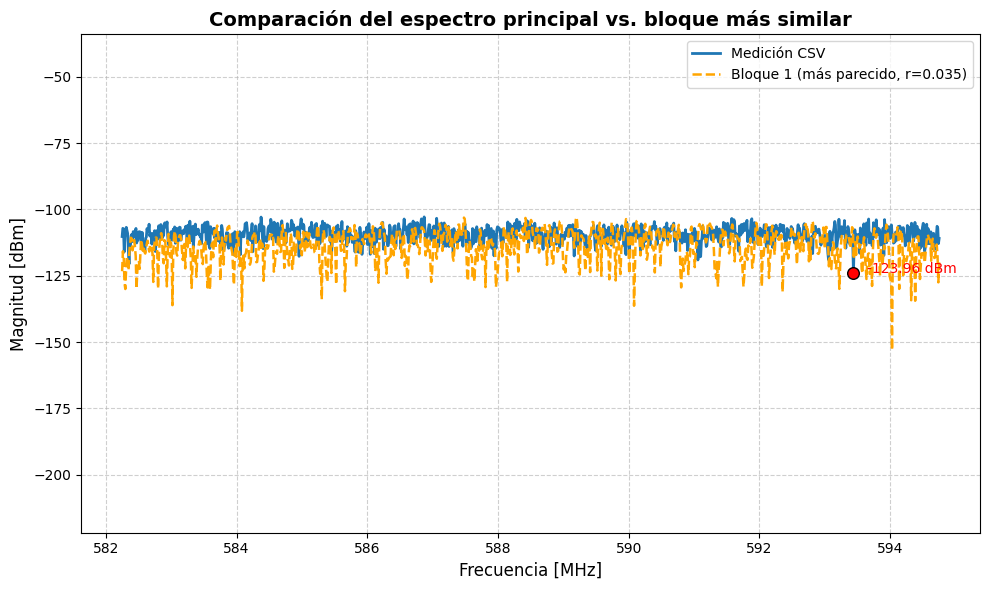

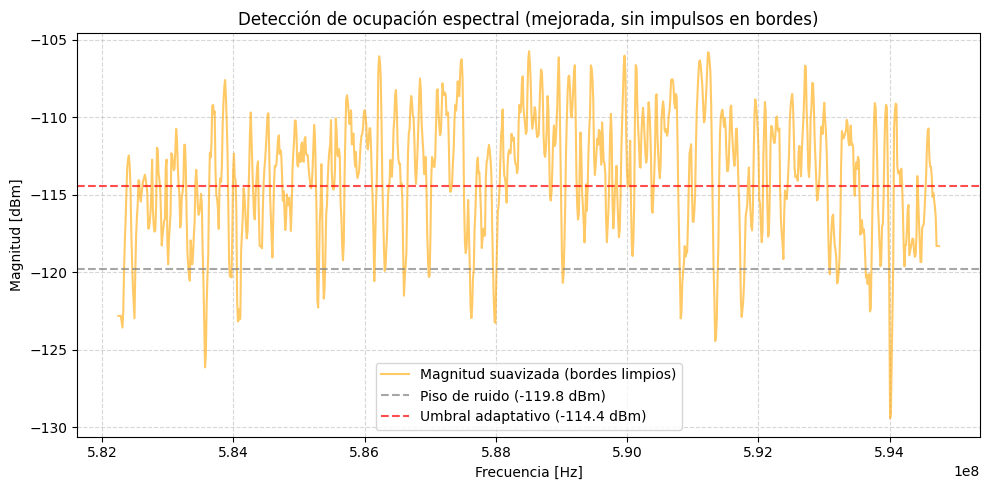


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -119.79 dBm
Desviación estándar del ruido: 2.14 dB
Umbral adaptativo: -114.45 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/588barrido010.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/588_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 11


→ El bloque más parecido es el #2 con correlación r = 0.1000


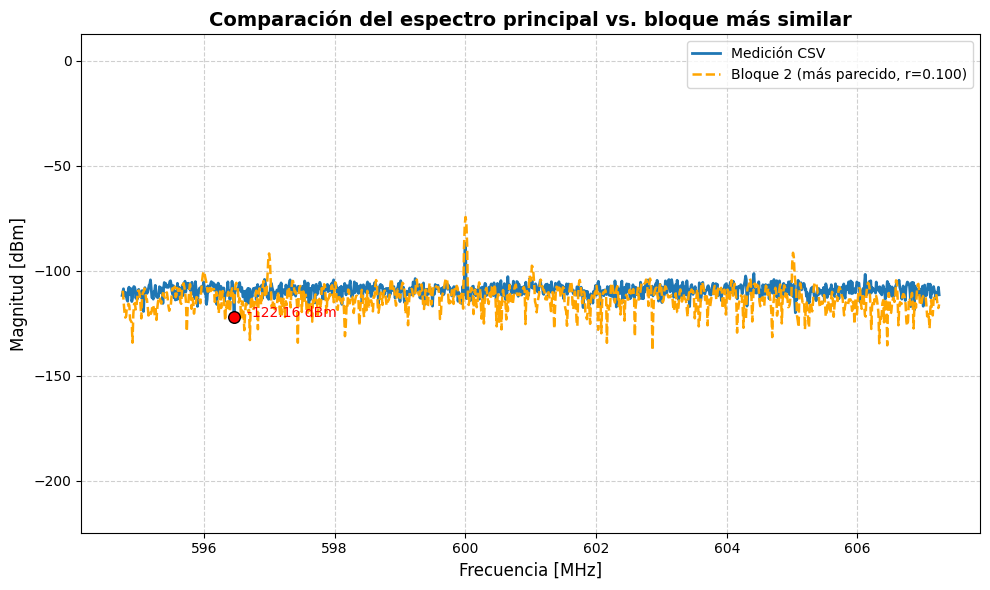

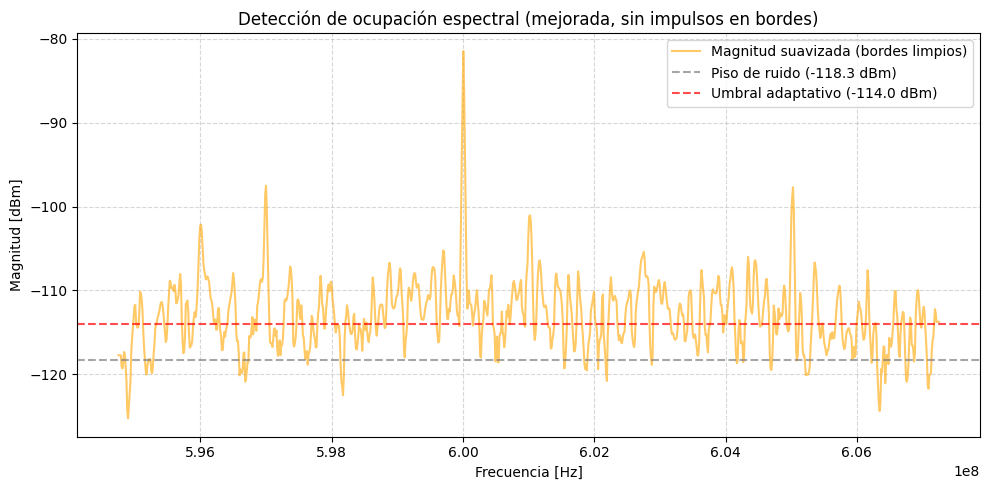


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -118.31 dBm
Desviación estándar del ruido: 1.71 dB
Umbral adaptativo: -114.04 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/601barrido011.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/601M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 12


→ El bloque más parecido es el #1 con correlación r = 0.0727


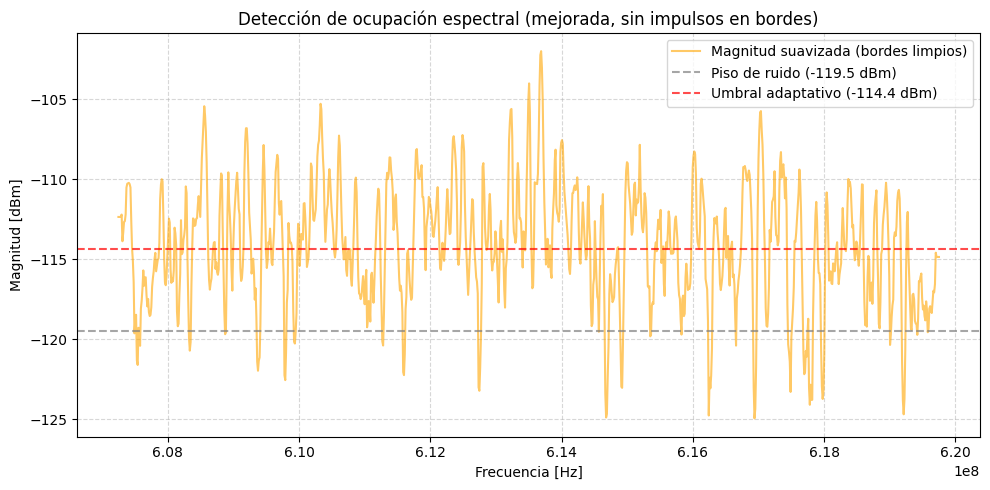


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -119.50 dBm
Desviación estándar del ruido: 2.06 dB
Umbral adaptativo: -114.35 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/613barrido012.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/613_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 13


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/626barrido013.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/626M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


→ El bloque más parecido es el #1 con correlación r = 0.0941



=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -118.89 dBm
Desviación estándar del ruido: 2.27 dB
Umbral adaptativo: -113.21 dBm

No se detectaron canales ocupados.


# BARRIDO 14


→ El bloque más parecido es el #2 con correlación r = 0.1895


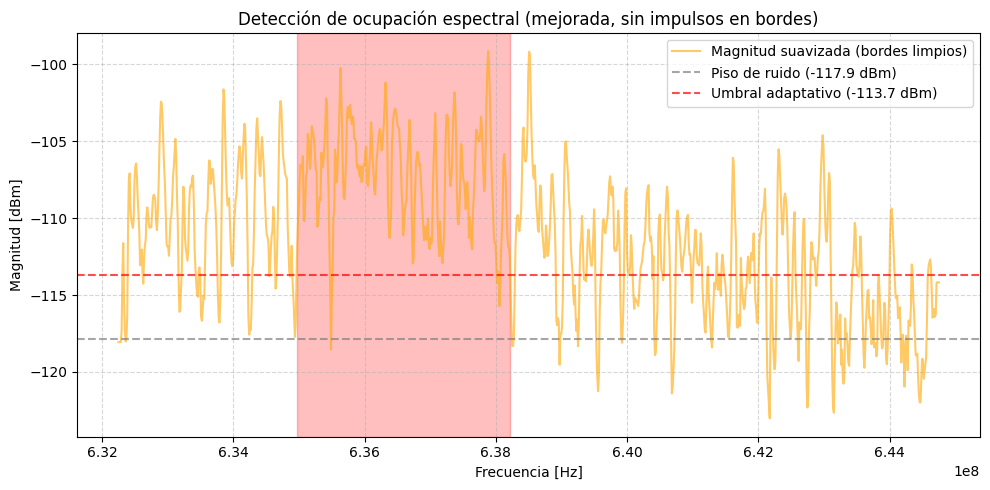


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -117.86 dBm
Desviación estándar del ruido: 1.65 dB
Umbral adaptativo: -113.73 dBm

Se detectaron 1 canales ocupados:
  Canal 1: 634.97 – 638.21 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/638barrido014.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/638_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 15


→ El bloque más parecido es el #2 con correlación r = 0.3302


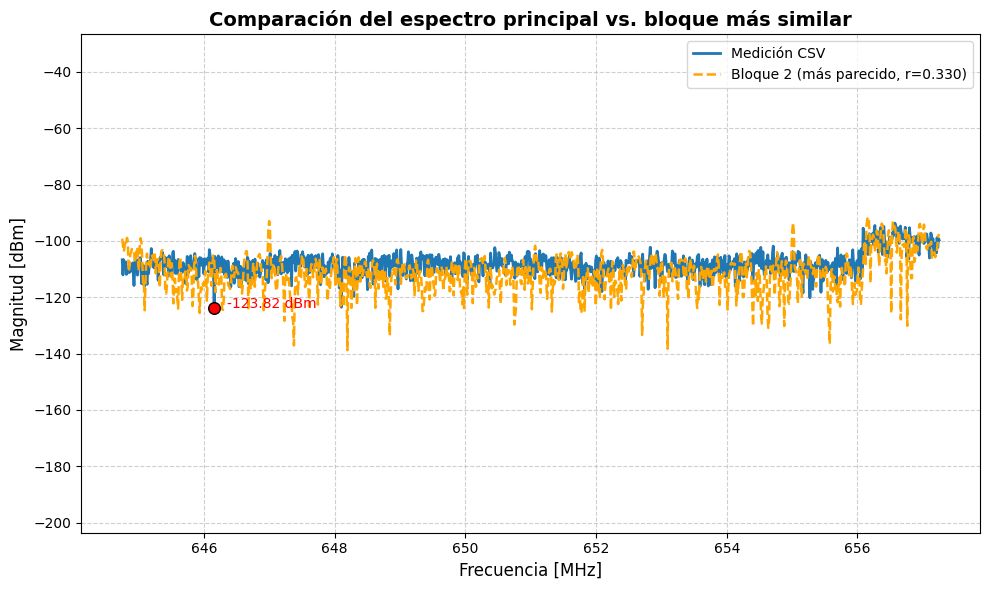

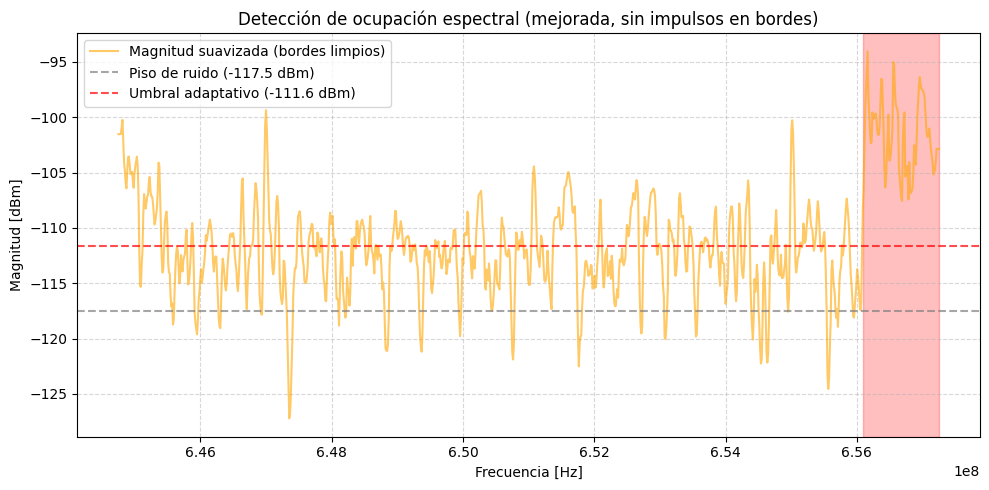


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -117.53 dBm
Desviación estándar del ruido: 2.37 dB
Umbral adaptativo: -111.61 dBm

Se detectaron 1 canales ocupados:
  Canal 1: 656.09 – 657.25 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/651barrido015.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/651M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 1
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 16


→ El bloque más parecido es el #2 con correlación r = 0.7143


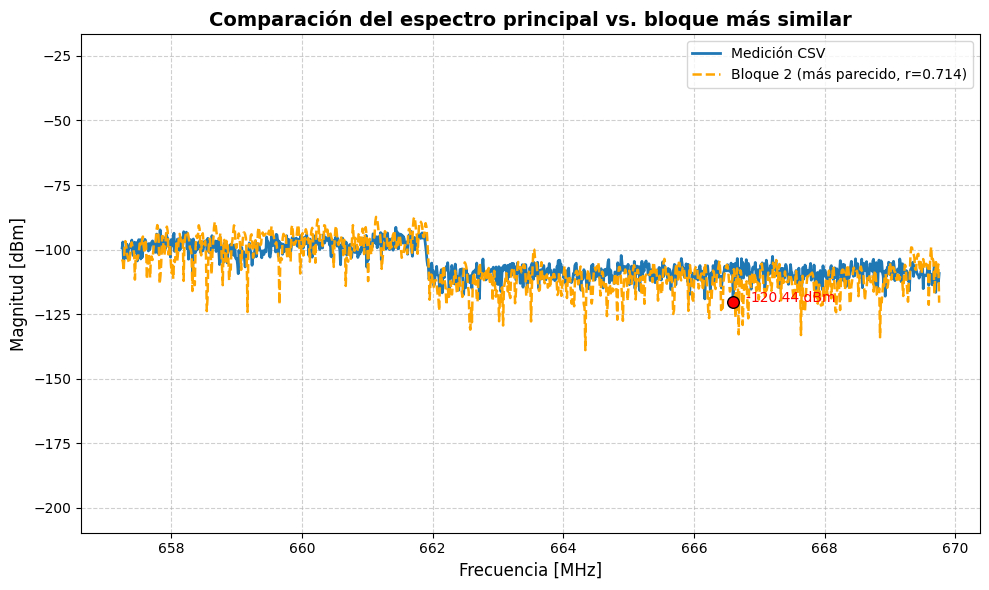

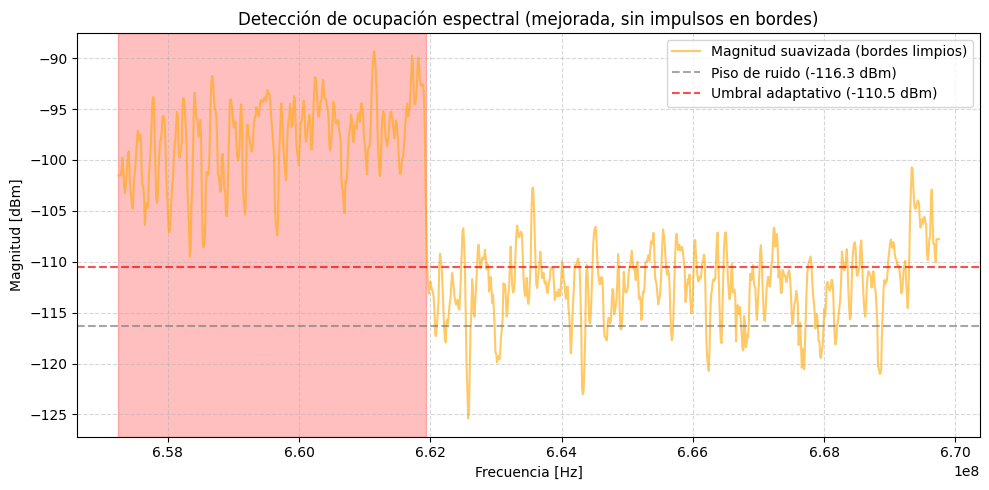


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -116.29 dBm
Desviación estándar del ruido: 2.33 dB
Umbral adaptativo: -110.47 dBm

Se detectaron 1 canales ocupados:
  Canal 1: 657.25 – 661.94 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/663barrido016.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/663_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 17


→ El bloque más parecido es el #1 con correlación r = 0.5154


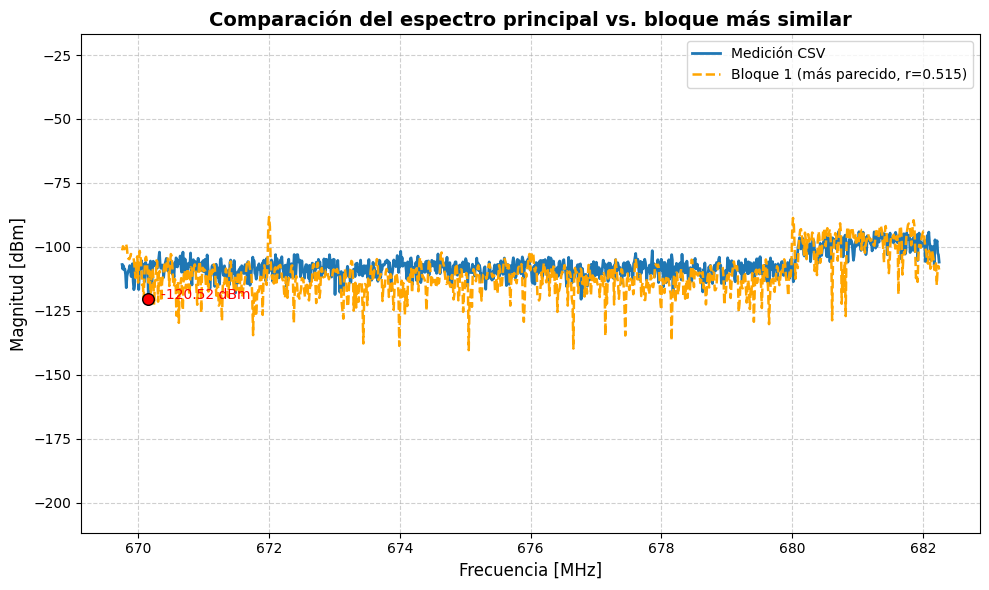

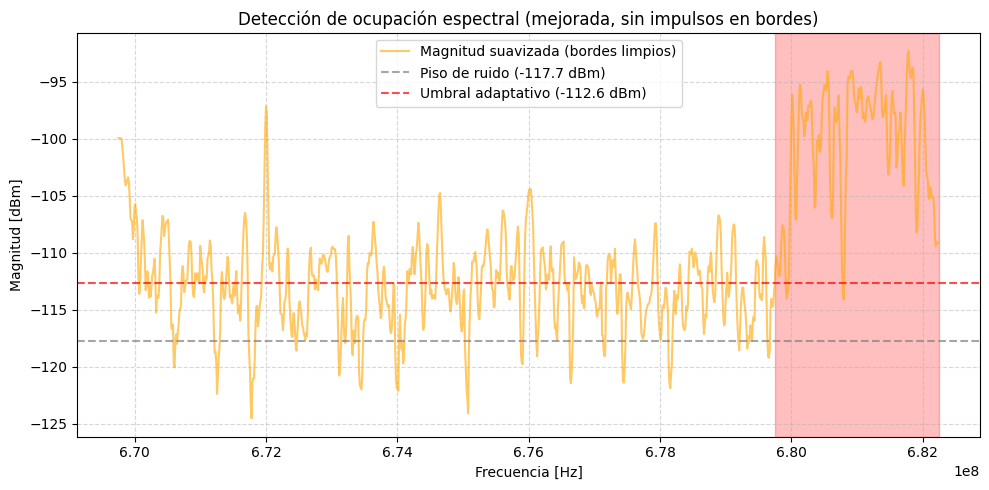


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -117.72 dBm
Desviación estándar del ruido: 2.03 dB
Umbral adaptativo: -112.64 dBm

Se detectaron 1 canales ocupados:
  Canal 1: 679.76 – 682.25 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/676barrido017.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/676M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


# BARRIDO 18


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/688barrido018.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/688_5M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


→ El bloque más parecido es el #2 con correlación r = 0.6972



=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -117.84 dBm
Desviación estándar del ruido: 1.67 dB
Umbral adaptativo: -113.66 dBm

Se detectaron 1 canales ocupados:
  Canal 1: 682.25 – 685.99 MHz


# BARRIDO 19


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/701barrido019.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/701M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1.2, ymax + abs(ymax - ymin)*1.2)

plt.tight_layout()
plt.show()

# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 5     # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")


→ El bloque más parecido es el #2 con correlación r = 0.1100



=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -119.82 dBm
Desviación estándar del ruido: 2.59 dB
Umbral adaptativo: -113.35 dBm

No se detectaron canales ocupados.


# BARRIDO TOTAL


→ Barrido 476.0 MHz: bloque #2 (r=0.076)
→ Barrido 488.5 MHz: bloque #1 (r=0.154)
→ Barrido 501.0 MHz: bloque #2 (r=0.053)
→ Barrido 513.5 MHz: bloque #1 (r=0.040)
→ Barrido 526.0 MHz: bloque #1 (r=-0.005)
→ Barrido 538.5 MHz: bloque #2 (r=0.003)
→ Barrido 551.0 MHz: bloque #2 (r=0.235)
→ Barrido 563.5 MHz: bloque #1 (r=0.007)
→ Barrido 576.0 MHz: bloque #2 (r=0.016)
→ Barrido 588.5 MHz: bloque #1 (r=0.035)
→ Barrido 601.0 MHz: bloque #2 (r=0.100)
→ Barrido 613.5 MHz: bloque #1 (r=0.073)
→ Barrido 626.0 MHz: bloque #1 (r=0.094)
→ Barrido 638.5 MHz: bloque #2 (r=0.190)
→ Barrido 651.0 MHz: bloque #2 (r=0.330)
→ Barrido 663.5 MHz: bloque #2 (r=0.714)
→ Barrido 676.0 MHz: bloque #1 (r=0.515)
→ Barrido 688.5 MHz: bloque #2 (r=0.697)
→ Barrido 701.0 MHz: bloque #2 (r=0.110)


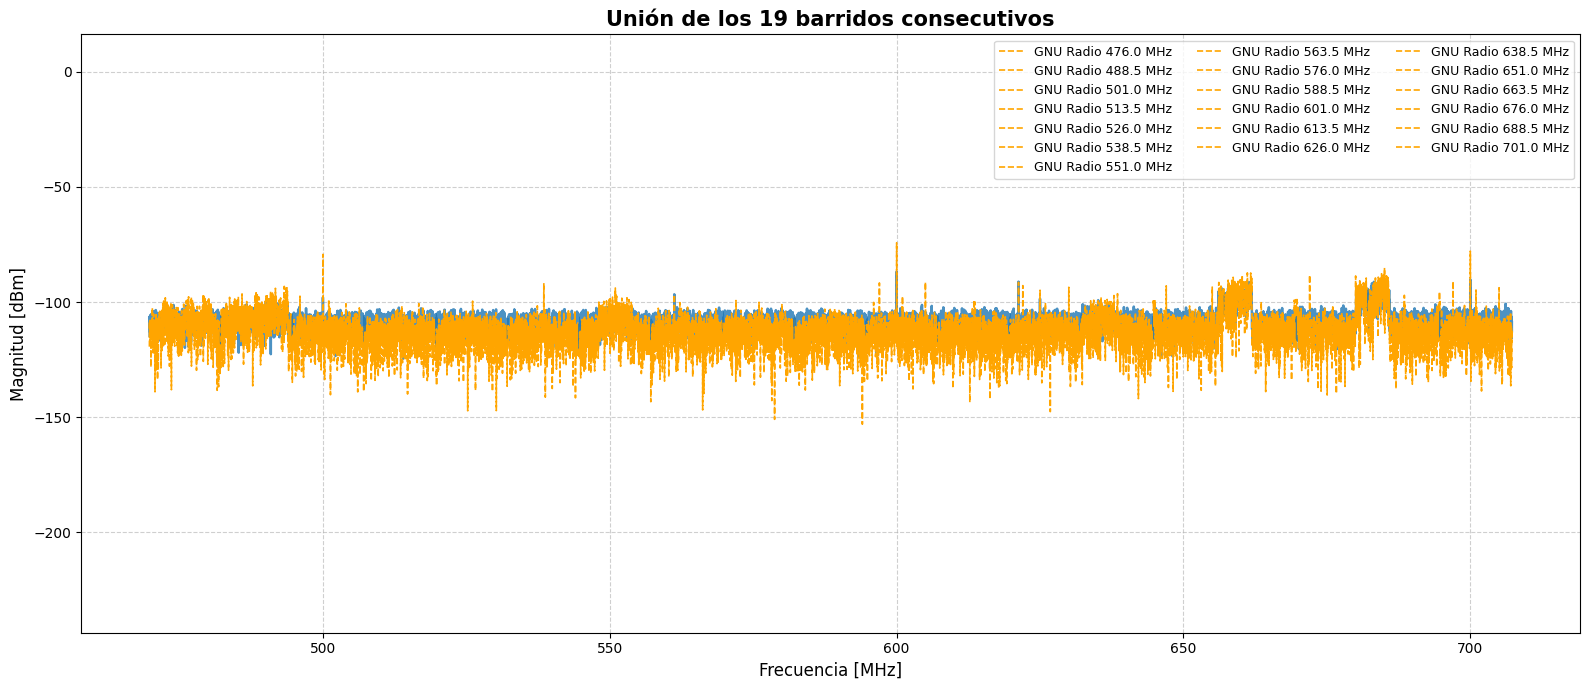

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from scipy.stats import pearsonr

# ============================================================
# === FUNCIÓN PARA CARGAR Y PROCESAR UN BARRIDO ==============
# ============================================================
def procesar_barrido(archivo_csv, archivo_txt):
    df = pd.read_csv(archivo_csv, header=None)
    start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1
    datos = df.iloc[start_idx:, [0, 1]].dropna()
    datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]
    datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
    datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
    datos = datos.dropna()

    mag_ref = datos["Magnitud [dBm]"].to_numpy()
    mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

    with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
        lineas = [l.strip() for l in f if l.strip()]

    freq_central = sample_rate = vector_len = None
    for linea in lineas:
        if "Frequency" in linea:
            freq_central = float(linea.split(":")[1])
        elif "Sample Rate" in linea:
            sample_rate = float(linea.split(":")[1])
        elif "Vector Length" in linea:
            vector_len = int(linea.split(":")[1])

    datos_txt = []
    for linea in lineas:
        if re.match(r"^[-\d\.\s,]+$", linea):
            valores = re.split(r"[\s,]+", linea.strip())
            numeros = []
            for v in valores:
                try:
                    if v.strip() not in ["", "-", "--"]:
                        numeros.append(float(v))
                except ValueError:
                    continue
            if len(numeros) > 1:
                datos_txt.append(numeros)

    freqs = np.linspace(freq_central - sample_rate / 2,
                        freq_central + sample_rate / 2,
                        vector_len)

    mejor_idx = -1
    mejor_corr = -2
    if len(mag_ref) != vector_len:
        mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                      np.linspace(0, 1, len(mag_ref)), mag_ref)
    else:
        mag_ref_resampled = mag_ref

    for i, bloque in enumerate(datos_txt):
        bloque = np.array(bloque)
        if len(bloque) == vector_len:
            bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
            corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
            if corr > mejor_corr:
                mejor_corr = corr
                mejor_idx = i

    print(f"→ Barrido {freq_central/1e6:.1f} MHz: bloque #{mejor_idx+1} (r={mejor_corr:.3f})")
    return datos, freqs, np.array(datos_txt[mejor_idx])

# ============================================================
# === LISTA DE LOS 19 BARRIDOS ===============================
# ============================================================
barridos = [
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/476barrido1.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/476M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/488barrido2.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/488_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/501barrido3.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/501M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/513barrido4.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/513_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/526barrido5.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/526M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/538barrido6.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/538_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/551barrido7.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/551M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/563barrido8.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/563_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/576barrido9.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/576M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/588barrido010.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/588_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/601barrido011.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/601M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/613barrido012.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/613_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/626barrido013.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/626M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/638barrido014.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/638_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/651barrido015.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/651M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/663barrido016.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/663_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/676barrido017.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/676M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/688barrido018.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/688_5M.csv"},
    {"csv": "/content/drive/MyDrive/ barrido_de_frecuencia_final/analizadorreal_frecuencias/701barrido019.csv",
     "txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/701M.csv"}
]

# ============================================================
# === PROCESAR Y GRAFICAR ===================================
# ============================================================
plt.figure(figsize=(16, 7))

for b in barridos:
    datos, freqs, bloque = procesar_barrido(b["csv"], b["txt"])
    fc = freqs[int(len(freqs)/2)] / 1e6
    plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
             color="#1f77b4", linewidth=1.8, alpha=0.8)
    plt.plot(freqs/1e6, bloque, linestyle='--', color='orange', linewidth=1.2,
             label=f"GNU Radio {fc:.1f} MHz")

plt.title("Unión de los 19 barridos consecutivos", fontsize=15, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(ncol=3, fontsize=9)

ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin), ymax + abs(ymax - ymin))

plt.tight_layout()
plt.show()


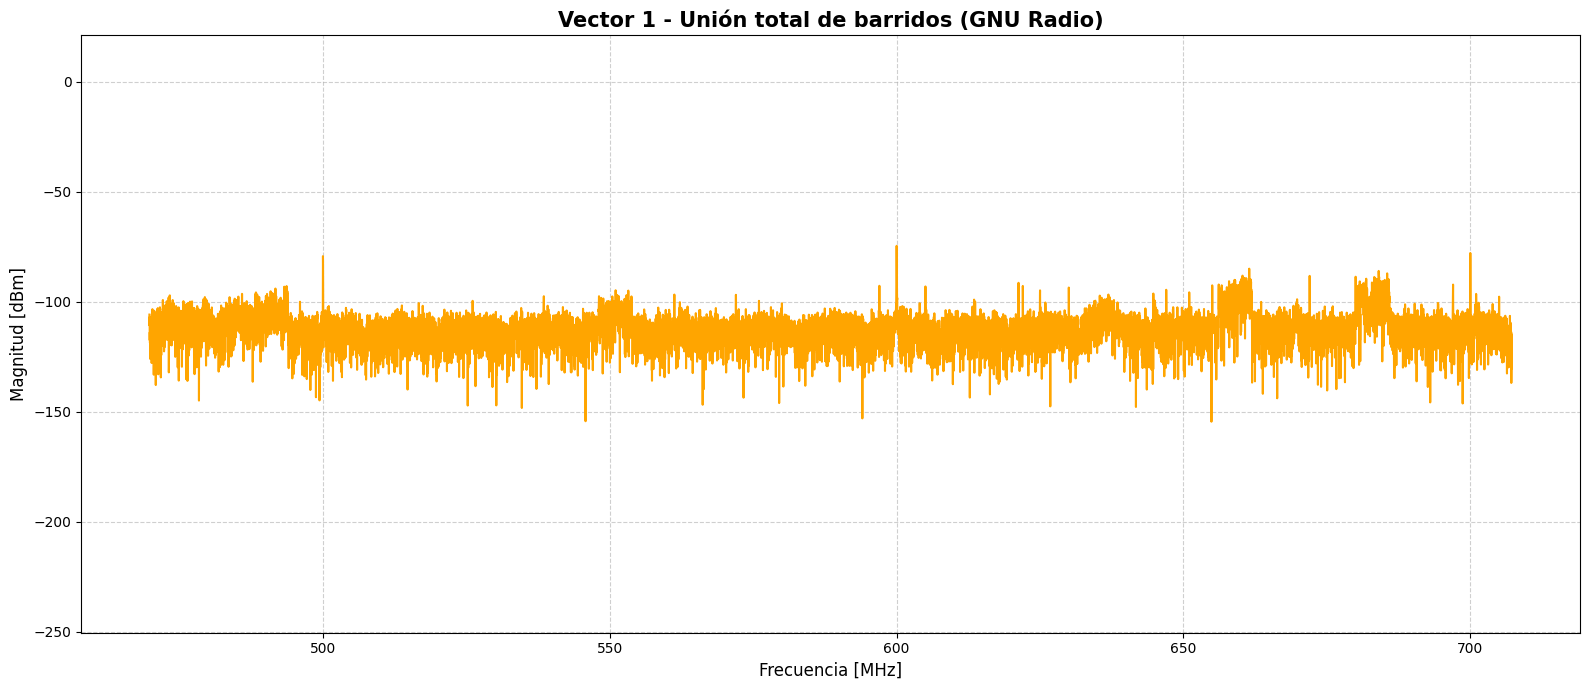

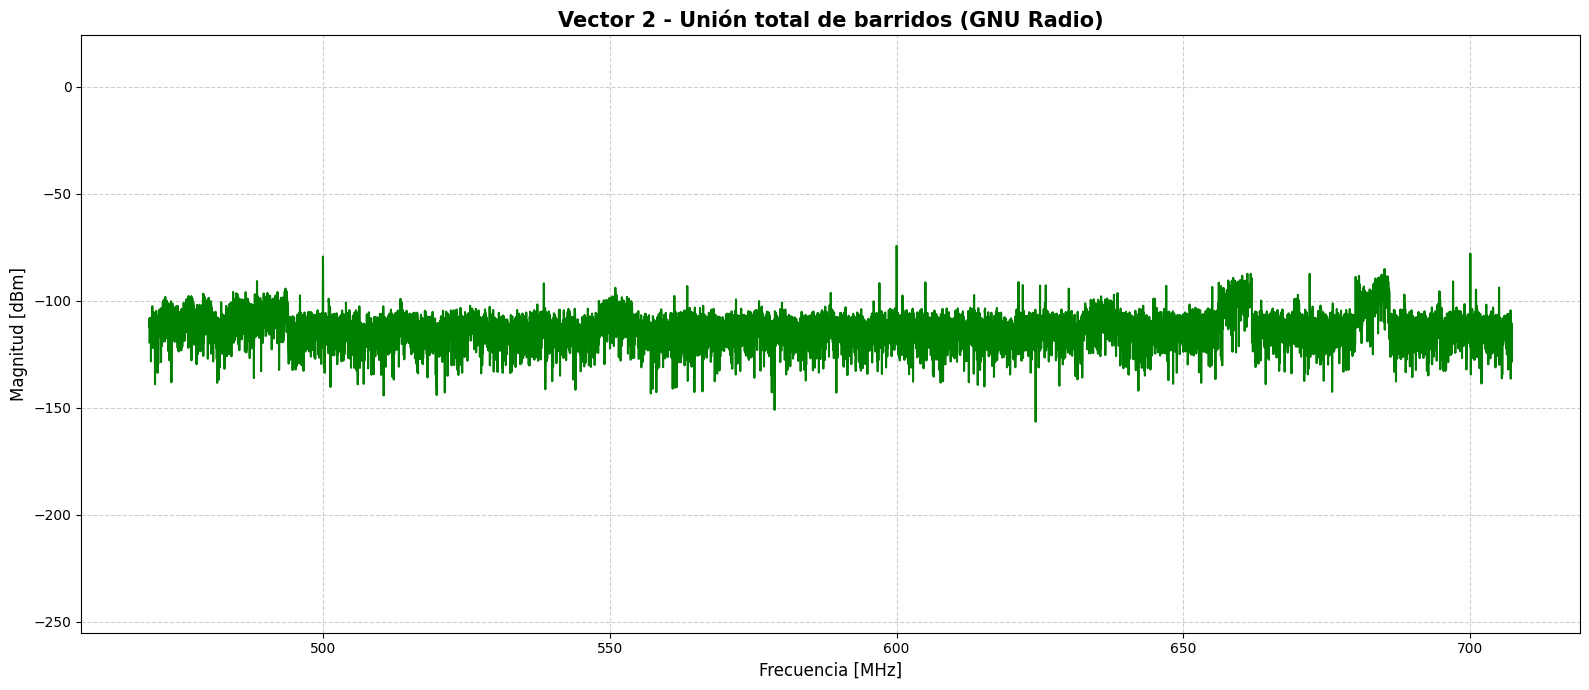

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ============================================================
# === FUNCIÓN PARA CARGAR Y PROCESAR UN BARRIDO ==============
# ============================================================
def procesar_barrido(archivo_txt):
    with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
        lineas = [l.strip() for l in f if l.strip()]

    # Leer parámetros
    freq_central = sample_rate = vector_len = None
    for linea in lineas:
        if "Frequency" in linea:
            freq_central = float(linea.split(":")[1])
        elif "Sample Rate" in linea:
            sample_rate = float(linea.split(":")[1])
        elif "Vector Length" in linea:
            vector_len = int(linea.split(":")[1])

    # Extraer los vectores numéricos
    datos_txt = []
    for linea in lineas:
        if re.match(r"^[-\d\.\s,]+$", linea):
            valores = re.split(r"[\s,]+", linea.strip())
            numeros = []
            for v in valores:
                try:
                    if v.strip() not in ["", "-", "--"]:
                        numeros.append(float(v))
                except ValueError:
                    continue
            if len(numeros) > 1:
                datos_txt.append(numeros)

    # Tomar los 3 primeros vectores válidos
    primeros_vectores = [np.array(v) for v in datos_txt[:3] if len(v) == vector_len]

    # Eje de frecuencias
    freqs = np.linspace(freq_central - sample_rate / 2,
                        freq_central + sample_rate / 2,
                        vector_len)

    return freqs, primeros_vectores, freq_central


# ============================================================
# === LISTA DE LOS 19 BARRIDOS ===============================
# ============================================================
barridos = [
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/476M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/488_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/501M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/513_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/526M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/538_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/551M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/563_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/576M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/588_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/601M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/613_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/626M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/638_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/651M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/663_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/676M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/688_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/701M.csv"}
]

# ============================================================
# === ACUMULAR LOS TRES GRUPOS DE VECTORES ===================
# ============================================================
freqs_total = []
vectores_1 = []
vectores_2 = []
vectores_3 = []

for b in barridos:
    freqs, primeros_vectores, fc = procesar_barrido(b["txt"])

    if len(primeros_vectores) >= 1:
        vectores_1.append(primeros_vectores[0])
    if len(primeros_vectores) >= 2:
        vectores_2.append(primeros_vectores[1])
    if len(primeros_vectores) >= 3:
        vectores_3.append(primeros_vectores[2])

    freqs_total.append(freqs)

# Concatenar los 19 barridos
freqs_concat = np.concatenate(freqs_total)
vec1_concat = np.concatenate(vectores_1)
vec2_concat = np.concatenate(vectores_2)
#vec3_concat = np.concatenate(vectores_3)

# ============================================================
# === FUNCIÓN PARA GRAFICAR CON REESCALADO ===================
# ============================================================
def graficar_vector(freqs, vector, titulo, color):
    plt.figure(figsize=(16, 7))
    plt.plot(freqs / 1e6, vector, color=color, linewidth=1.5)
    plt.title(titulo, fontsize=15, weight='bold')
    plt.xlabel("Frecuencia [MHz]", fontsize=12)
    plt.ylabel("Magnitud [dBm]", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Reescalado simétrico en Y
    ymin, ymax = np.min(vector), np.max(vector)
    rango = ymax - ymin
    plt.ylim(ymin - rango * 1.2, ymax + rango * 1.2)  # 0.5 = expande 50% hacia arriba y abajo

    plt.tight_layout()
    plt.show()

# ============================================================
# === GRAFICAR CADA VECTOR CONCATENADO POR SEPARADO ==========
# ============================================================
graficar_vector(freqs_concat, vec1_concat, "Vector 1 - Unión total de barridos (GNU Radio)", "orange")
graficar_vector(freqs_concat, vec2_concat, "Vector 2 - Unión total de barridos (GNU Radio)", "green")
#graficar_vector(freqs_concat, vec3_concat, "Vector 3 - Unión total de barridos (GNU Radio)", "purple")


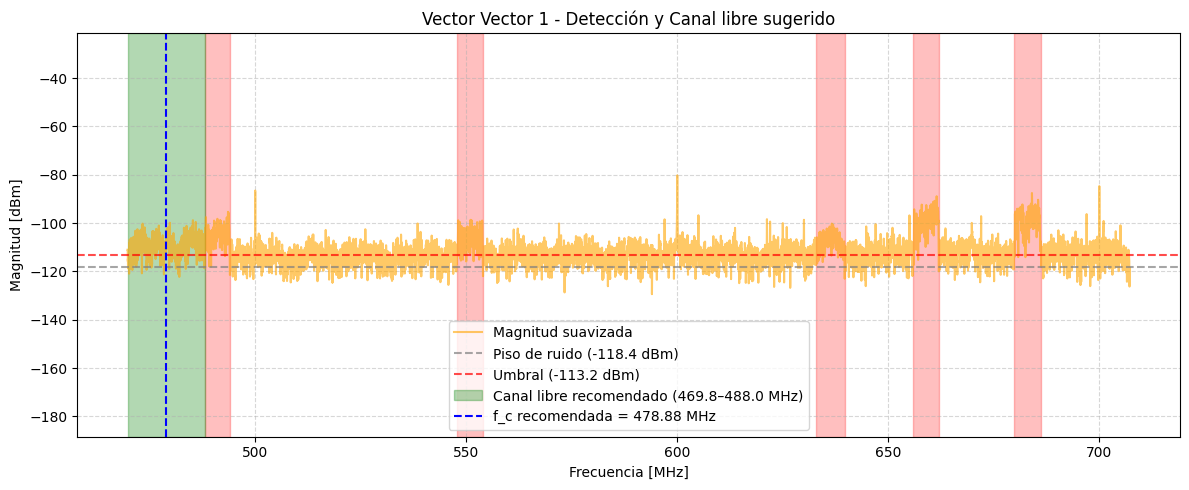


=== VECTOR 1 ===
Piso de ruido: -118.38 dBm
Umbral: -113.19 dBm
Canales ocupados detectados: 5
  Canal 1: 488.01 – 493.96 MHz
  Canal 2: 547.83 – 553.91 MHz
  Canal 3: 632.93 – 639.64 MHz
  Canal 4: 655.78 – 661.93 MHz
  Canal 5: 679.75 – 686.16 MHz

Canal libre sugerido: 679.75 – 686.16 MHz
Frecuencia central recomendada: 478.88 MHz


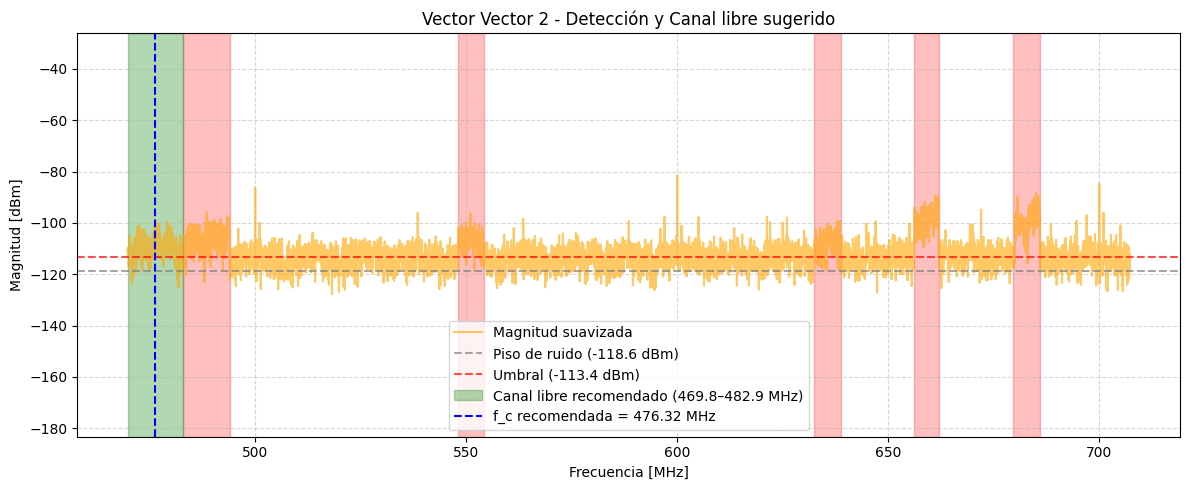


=== VECTOR 2 ===
Piso de ruido: -118.55 dBm
Umbral: -113.44 dBm
Canales ocupados detectados: 5
  Canal 1: 482.89 – 493.94 MHz
  Canal 2: 548.05 – 554.11 MHz
  Canal 3: 632.32 – 638.91 MHz
  Canal 4: 656.08 – 662.04 MHz
  Canal 5: 679.57 – 685.99 MHz

Canal libre sugerido: 679.57 – 685.99 MHz
Frecuencia central recomendada: 476.32 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ============================================================
# === FUNCIÓN PARA CARGAR Y PROCESAR UN BARRIDO ==============
# ============================================================
def procesar_barrido(archivo_txt):
    with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
        lineas = [l.strip() for l in f if l.strip()]

    # Leer parámetros
    freq_central = sample_rate = vector_len = None
    for linea in lineas:
        if "Frequency" in linea:
            freq_central = float(linea.split(":")[1])
        elif "Sample Rate" in linea:
            sample_rate = float(linea.split(":")[1])
        elif "Vector Length" in linea:
            vector_len = int(linea.split(":")[1])

    # Extraer los vectores numéricos
    datos_txt = []
    for linea in lineas:
        if re.match(r"^[-\d\.\s,]+$", linea):
            valores = re.split(r"[\s,]+", linea.strip())
            numeros = []
            for v in valores:
                try:
                    if v.strip() not in ["", "-", "--"]:
                        numeros.append(float(v))
                except ValueError:
                    continue
            if len(numeros) > 1:
                datos_txt.append(numeros)

    # Tomar los 3 primeros vectores válidos
    primeros_vectores = [np.array(v) for v in datos_txt[:3] if len(v) == vector_len]

    # Eje de frecuencias
    freqs = np.linspace(freq_central - sample_rate / 2,
                        freq_central + sample_rate / 2,
                        vector_len)

    return freqs, primeros_vectores, freq_central


# ============================================================
# === LISTA DE LOS 19 BARRIDOS ===============================
# ============================================================
barridos = [
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/476M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/488_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/501M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/513_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/526M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/538_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/551M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/563_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/576M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/588_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/601M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/613_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/626M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/638_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/651M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/663_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/676M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/688_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/701M.csv"}
]

# ============================================================
# === ACUMULAR LOS TRES GRUPOS DE VECTORES ===================
# ============================================================
freqs_total = []
vectores_1 = []
vectores_2 = []
vectores_3 = []

for b in barridos:
    freqs, primeros_vectores, fc = procesar_barrido(b["txt"])
    if len(primeros_vectores) >= 1:
        vectores_1.append(primeros_vectores[0])
    if len(primeros_vectores) >= 2:
        vectores_2.append(primeros_vectores[1])
    if len(primeros_vectores) >= 3:
        vectores_3.append(primeros_vectores[2])
    freqs_total.append(freqs)

# Concatenar los 19 barridos
freqs_concat = np.concatenate(freqs_total)
vec1_concat = np.concatenate(vectores_1)
vec2_concat = np.concatenate(vectores_2)
# vec3_concat = np.concatenate(vectores_3)

# ============================================================
# === DETECCIÓN DE OCUPACIÓN Y RECOMENDACIÓN DE FRECUENCIA ===
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# --- Parámetros generales ---
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 5
tolerancia_puntos = 6
porcentaje_ruido = 20
gap_permitido = 6
ancho_libre_MHz = 6   # Canal libre mínimo (3 MHz a cada lado)

# --- Función de detección y recomendación ---
def detectar_y_recomendar(freqs, magnitud, nombre_vector):
    # === 1. Suavizado ===
    magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
    magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

    # === 2. Eliminar impulsos en extremos ===
    margen = 3
    magnitud_suav[:margen] = magnitud_suav[margen]
    magnitud_suav[-margen:] = magnitud_suav[-margen-1]

    # === 3. Piso de ruido ===
    n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
    indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
    piso_ruido = np.mean(magnitud_suav[indices_ruido])
    sigma_ruido = np.std(magnitud_suav[indices_ruido])
    umbral = piso_ruido + k_sigma * sigma_ruido

    # === 4. Detección de ocupación ===
    mask_ocupado = magnitud_suav > umbral

    canales_ocupados = []
    inicio = None
    gap_count = 0

    for i in range(len(mask_ocupado)):
        if mask_ocupado[i]:
            if inicio is None:
                inicio = i
            gap_count = 0
        else:
            if inicio is not None:
                gap_count += 1
                if gap_count > gap_permitido:
                    fin = i - gap_count + 1
                    if fin - inicio >= tolerancia_puntos:
                        f_inicio = freqs[inicio]
                        f_fin = freqs[fin - 1]
                        ancho = abs(f_fin - f_inicio)
                        if ancho >= min_ancho_MHz * 1e6:
                            canales_ocupados.append((f_inicio, f_fin))
                    inicio = None
                    gap_count = 0

    if inicio is not None:
        f_inicio = freqs[inicio]
        f_fin = freqs[-1]
        ancho = abs(f_fin - f_inicio)
        if ancho >= min_ancho_MHz * 1e6:
            canales_ocupados.append((f_inicio, f_fin))

    # === 5. Buscar canal libre de al menos 6 MHz ===
    canales_libres = []
    f_min, f_max = freqs[0], freqs[-1]
    for (f1, f2) in canales_ocupados:
        canales_libres.append((f_min, f1))
        f_min = f2
    canales_libres.append((f_min, f_max))

    canal_libre = None
    f_c_recomendada = None
    for (f1, f2) in canales_libres:
        ancho = (f2 - f1) / 1e6
        if ancho >= ancho_libre_MHz:
            canal_libre = (f1, f2)
            f_c_recomendada = (f1 + f2) / 2
            break

    # === 6. Visualización ===
    plt.figure(figsize=(12, 5))
    plt.plot(freqs / 1e6, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada')
    plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
    plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral ({umbral:.1f} dBm)')

    for (f_ini, f_fin) in canales_ocupados:
        plt.axvspan(f_ini / 1e6, f_fin / 1e6, color='red', alpha=0.25)

    if canal_libre:
        f1, f2 = canal_libre
        plt.axvspan(f1 / 1e6, f2 / 1e6, color='green', alpha=0.3,
                    label=f"Canal libre recomendado ({f1/1e6:.1f}–{f2/1e6:.1f} MHz)")
        plt.axvline(f_c_recomendada / 1e6, color='blue', linestyle='--',
                    label=f"f_c recomendada = {f_c_recomendada/1e6:.2f} MHz")

    # === Reescalado simétrico en Y ===
    ymin, ymax = np.min(magnitud_suav), np.max(magnitud_suav)
    rango = ymax - ymin
    plt.ylim(ymin - rango * 1.2, ymax + rango * 1.2)

    plt.title(f"Vector {nombre_vector} - Detección y Canal libre sugerido")
    plt.xlabel("Frecuencia [MHz]")
    plt.ylabel("Magnitud [dBm]")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === 7. Reporte ===
    print(f"\n=== {nombre_vector.upper()} ===")
    print(f"Piso de ruido: {piso_ruido:.2f} dBm")
    print(f"Umbral: {umbral:.2f} dBm")
    if canales_ocupados:
        print(f"Canales ocupados detectados: {len(canales_ocupados)}")
        for i, (f1, f2) in enumerate(canales_ocupados, 1):
            print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
    else:
        print("No se detectaron canales ocupados.")
    if canal_libre:
        print(f"\nCanal libre sugerido: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
        print(f"Frecuencia central recomendada: {f_c_recomendada/1e6:.2f} MHz")
    else:
        print("\nNo se encontró un canal completamente libre de 6 MHz.")

# --- Ejecutar para cada vector ---
detectar_y_recomendar(freqs_concat, vec1_concat, "Vector 1")
detectar_y_recomendar(freqs_concat, vec2_concat, "Vector 2")
#detectar_y_recomendar(freqs_concat, vec3_concat, "Vector 3")


INTENTO DEFINITIVO CANAL LIBRE

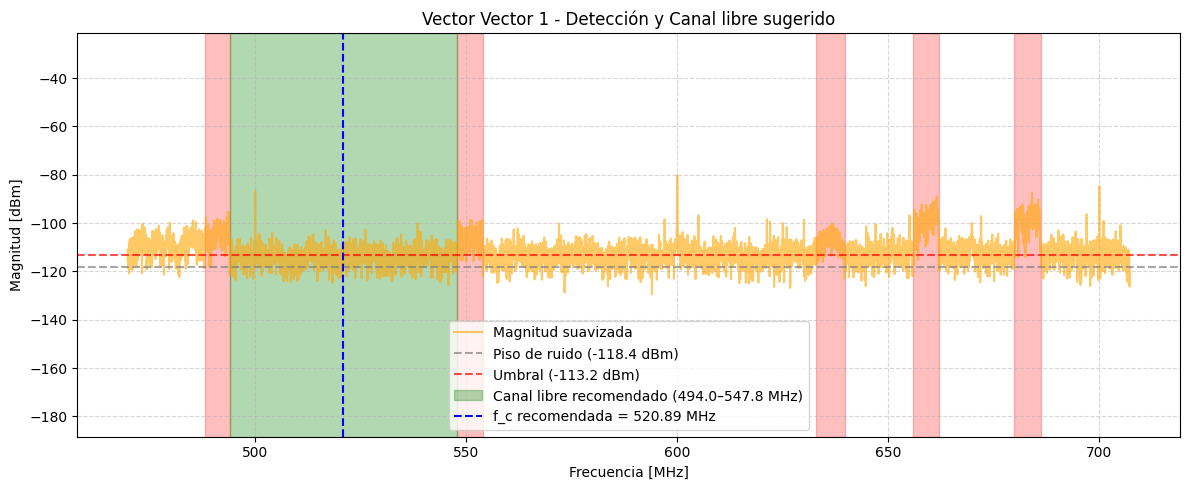


=== VECTOR 1 ===
Piso de ruido: -118.38 dBm
Umbral: -113.19 dBm
Canales ocupados detectados: 5
  Canal 1: 488.01 – 493.96 MHz
  Canal 2: 547.83 – 553.91 MHz
  Canal 3: 632.93 – 639.64 MHz
  Canal 4: 655.78 – 661.93 MHz
  Canal 5: 679.75 – 686.16 MHz

Canales libres disponibles (≥6 MHz):
  Libre 1: 469.75 – 488.01 MHz  |  Potencia promedio = -109.67 dBm
  Libre 2: 493.96 – 547.83 MHz  |  Potencia promedio = -113.86 dBm
  Libre 3: 553.91 – 632.93 MHz  |  Potencia promedio = -113.47 dBm
  Libre 4: 639.64 – 655.78 MHz  |  Potencia promedio = -112.71 dBm
  Libre 5: 661.93 – 679.75 MHz  |  Potencia promedio = -112.40 dBm
  Libre 6: 686.16 – 707.25 MHz  |  Potencia promedio = -112.97 dBm

Canal libre recomendado (más silencioso): 686.16 – 707.25 MHz
Frecuencia central recomendada: 520.89 MHz


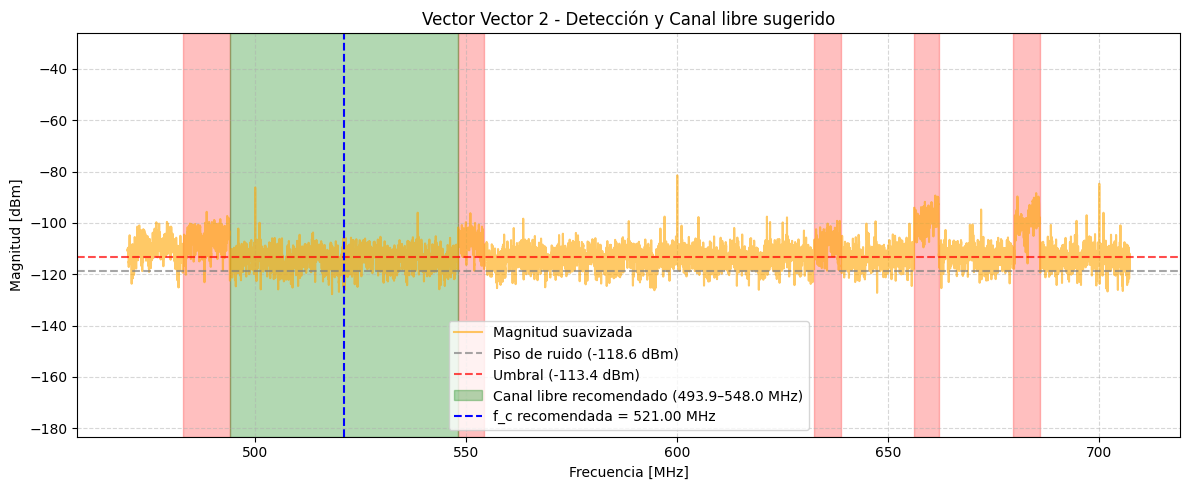


=== VECTOR 2 ===
Piso de ruido: -118.55 dBm
Umbral: -113.44 dBm
Canales ocupados detectados: 5
  Canal 1: 482.89 – 493.94 MHz
  Canal 2: 548.05 – 554.11 MHz
  Canal 3: 632.32 – 638.91 MHz
  Canal 4: 656.08 – 662.04 MHz
  Canal 5: 679.57 – 685.99 MHz

Canales libres disponibles (≥6 MHz):
  Libre 1: 469.75 – 482.89 MHz  |  Potencia promedio = -109.89 dBm
  Libre 2: 493.94 – 548.05 MHz  |  Potencia promedio = -113.74 dBm
  Libre 3: 554.11 – 632.32 MHz  |  Potencia promedio = -113.57 dBm
  Libre 4: 638.91 – 656.08 MHz  |  Potencia promedio = -112.90 dBm
  Libre 5: 662.04 – 679.57 MHz  |  Potencia promedio = -112.72 dBm
  Libre 6: 685.99 – 707.25 MHz  |  Potencia promedio = -113.18 dBm

Canal libre recomendado (más silencioso): 685.99 – 707.25 MHz
Frecuencia central recomendada: 521.00 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# ============================================================
# === FUNCIÓN PARA CARGAR Y PROCESAR UN BARRIDO ==============
# ============================================================
def procesar_barrido(archivo_txt):
    with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
        lineas = [l.strip() for l in f if l.strip()]

    # Leer parámetros
    freq_central = sample_rate = vector_len = None
    for linea in lineas:
        if "Frequency" in linea:
            freq_central = float(linea.split(":")[1])
        elif "Sample Rate" in linea:
            sample_rate = float(linea.split(":")[1])
        elif "Vector Length" in linea:
            vector_len = int(linea.split(":")[1])

    # Extraer los vectores numéricos
    datos_txt = []
    for linea in lineas:
        if re.match(r"^[-\d\.\s,]+$", linea):
            valores = re.split(r"[\s,]+", linea.strip())
            numeros = []
            for v in valores:
                try:
                    if v.strip() not in ["", "-", "--"]:
                        numeros.append(float(v))
                except ValueError:
                    continue
            if len(numeros) > 1:
                datos_txt.append(numeros)

    # Tomar los 3 primeros vectores válidos
    primeros_vectores = [np.array(v) for v in datos_txt[:3] if len(v) == vector_len]

    # Eje de frecuencias
    freqs = np.linspace(freq_central - sample_rate / 2,
                        freq_central + sample_rate / 2,
                        vector_len)

    return freqs, primeros_vectores, freq_central


# ============================================================
# === LISTA DE LOS 19 BARRIDOS ===============================
# ============================================================
barridos = [
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/476M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/488_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/501M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/513_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/526M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/538_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/551M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/563_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/576M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/588_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/601M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/613_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/626M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/638_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/651M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/663_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/676M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/688_5M.csv"},
    {"txt": "/content/drive/MyDrive/ barrido_de_frecuencia_final/gnuradioreal_frecuencias/701M.csv"}
]


# ============================================================
# === ACUMULAR LOS TRES GRUPOS DE VECTORES ===================
# ============================================================
freqs_total = []
vectores_1 = []
vectores_2 = []
vectores_3 = []

for b in barridos:
    freqs, primeros_vectores, fc = procesar_barrido(b["txt"])
    if len(primeros_vectores) >= 1:
        vectores_1.append(primeros_vectores[0])
    if len(primeros_vectores) >= 2:
        vectores_2.append(primeros_vectores[1])
    if len(primeros_vectores) >= 3:
        vectores_3.append(primeros_vectores[2])
    freqs_total.append(freqs)

# Concatenar los 19 barridos
freqs_concat = np.concatenate(freqs_total)
vec1_concat = np.concatenate(vectores_1)
vec2_concat = np.concatenate(vectores_2)
# vec3_concat = np.concatenate(vectores_3)


# ============================================================
# === DETECCIÓN DE OCUPACIÓN Y RECOMENDACIÓN DE FRECUENCIA ===
# ============================================================

# --- Parámetros generales ---
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 5
tolerancia_puntos = 6
porcentaje_ruido = 20
gap_permitido = 6
ancho_libre_MHz = 6   # Canal libre mínimo (3 MHz a cada lado)


def detectar_y_recomendar(freqs, magnitud, nombre_vector):
    # === 1. Suavizado ===
    magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
    magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

    # === 2. Eliminar impulsos en extremos ===
    margen = 3
    magnitud_suav[:margen] = magnitud_suav[margen]
    magnitud_suav[-margen:] = magnitud_suav[-margen-1]

    # === 3. Piso de ruido ===
    n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
    indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
    piso_ruido = np.mean(magnitud_suav[indices_ruido])
    sigma_ruido = np.std(magnitud_suav[indices_ruido])
    umbral = piso_ruido + k_sigma * sigma_ruido

    # === 4. Detección de ocupación ===
    mask_ocupado = magnitud_suav > umbral

    canales_ocupados = []
    inicio = None
    gap_count = 0

    for i in range(len(mask_ocupado)):
        if mask_ocupado[i]:
            if inicio is None:
                inicio = i
            gap_count = 0
        else:
            if inicio is not None:
                gap_count += 1
                if gap_count > gap_permitido:
                    fin = i - gap_count + 1
                    if fin - inicio >= tolerancia_puntos:
                        f_inicio = freqs[inicio]
                        f_fin = freqs[fin - 1]
                        ancho = abs(f_fin - f_inicio)
                        if ancho >= min_ancho_MHz * 1e6:
                            canales_ocupados.append((f_inicio, f_fin))
                    inicio = None
                    gap_count = 0

    if inicio is not None:
        f_inicio = freqs[inicio]
        f_fin = freqs[-1]
        ancho = abs(f_fin - f_inicio)
        if ancho >= min_ancho_MHz * 1e6:
            canales_ocupados.append((f_inicio, f_fin))

    # === 5. Buscar canal libre de al menos 6 MHz ===
    canales_libres = []
    f_min, f_max = freqs[0], freqs[-1]
    for (f1, f2) in canales_ocupados:
        canales_libres.append((f_min, f1))
        f_min = f2
    canales_libres.append((f_min, f_max))

    # Filtrar solo huecos ≥ ancho_libre_MHz y evaluar potencia promedio
    candidatos = []
    for (f1, f2) in canales_libres:
        ancho = (f2 - f1) / 1e6
        if ancho >= ancho_libre_MHz:
            idx = np.where((freqs >= f1) & (freqs <= f2))[0]
            if len(idx) > 0:
                potencia_prom = np.mean(magnitud_suav[idx])
                candidatos.append((f1, f2, potencia_prom))

    # Elegir el hueco más silencioso (menor potencia promedio)
    canal_libre = None
    f_c_recomendada = None
    if candidatos:
        canal_libre = min(candidatos, key=lambda x: x[2])[:2]
        f1, f2 = canal_libre
        f_c_recomendada = (f1 + f2) / 2

    # === 6. Visualización ===
    plt.figure(figsize=(12, 5))
    plt.plot(freqs / 1e6, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada')
    plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
    plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral ({umbral:.1f} dBm)')

    for (f_ini, f_fin) in canales_ocupados:
        plt.axvspan(f_ini / 1e6, f_fin / 1e6, color='red', alpha=0.25)

    if canal_libre:
        f1, f2 = canal_libre
        plt.axvspan(f1 / 1e6, f2 / 1e6, color='green', alpha=0.3,
                    label=f"Canal libre recomendado ({f1/1e6:.1f}–{f2/1e6:.1f} MHz)")
        plt.axvline(f_c_recomendada / 1e6, color='blue', linestyle='--',
                    label=f"f_c recomendada = {f_c_recomendada/1e6:.2f} MHz")

    # Reescalado simétrico en Y
    ymin, ymax = np.min(magnitud_suav), np.max(magnitud_suav)
    rango = ymax - ymin
    plt.ylim(ymin - rango * 1.2, ymax + rango * 1.2)

    plt.title(f"Vector {nombre_vector} - Detección y Canal libre sugerido")
    plt.xlabel("Frecuencia [MHz]")
    plt.ylabel("Magnitud [dBm]")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.show()

    # === 7. Reporte ===
    print(f"\n=== {nombre_vector.upper()} ===")
    print(f"Piso de ruido: {piso_ruido:.2f} dBm")
    print(f"Umbral: {umbral:.2f} dBm")
    if canales_ocupados:
        print(f"Canales ocupados detectados: {len(canales_ocupados)}")
        for i, (f1, f2) in enumerate(canales_ocupados, 1):
            print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
    else:
        print("No se detectaron canales ocupados.")

    if candidatos:
        print("\nCanales libres disponibles (≥6 MHz):")
        for i, (f1, f2, p) in enumerate(candidatos, 1):
            print(f"  Libre {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz  |  Potencia promedio = {p:.2f} dBm")

    if canal_libre:
        print(f"\nCanal libre recomendado (más silencioso): {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
        print(f"Frecuencia central recomendada: {f_c_recomendada/1e6:.2f} MHz")
    else:
        print("\nNo se encontró un canal completamente libre de 6 MHz.")


# --- Ejecutar para cada vector ---
detectar_y_recomendar(freqs_concat, vec1_concat, "Vector 1")
detectar_y_recomendar(freqs_concat, vec2_concat, "Vector 2")
# detectar_y_recomendar(freqs_concat, vec3_concat, "Vector 3")


GENERADOER VS GNU

→ El bloque más parecido es el #3 con correlación r = 0.8946


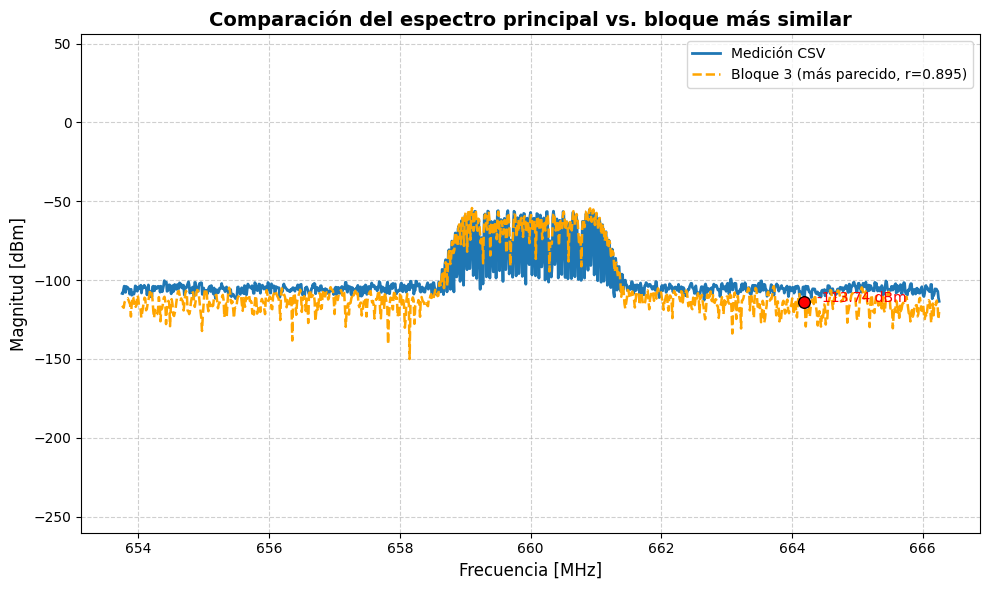


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -118.97 dBm
Desviación estándar del ruido: 1.74 dB
Umbral adaptativo: -114.63 dBm

Se detectaron 1 canales ocupados:
  Canal 1: 658.43 – 662.63 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/GeneradorSENAL.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/generador660M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1, ymax + abs(ymax - ymin)*1)

plt.tight_layout()
plt.show()
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 3
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 2   # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")

→ El bloque más parecido es el #2 con correlación r = 0.9021


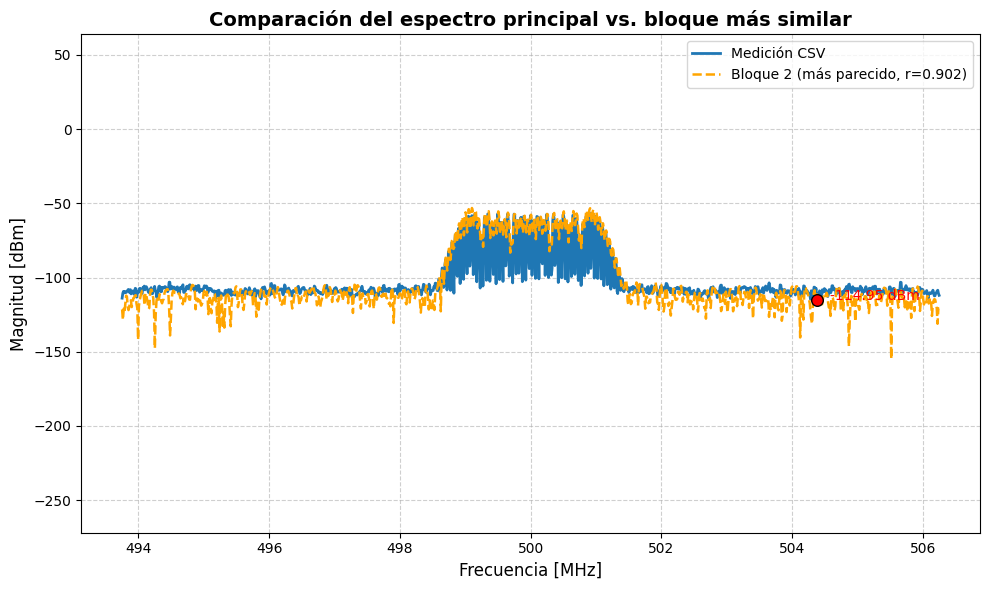

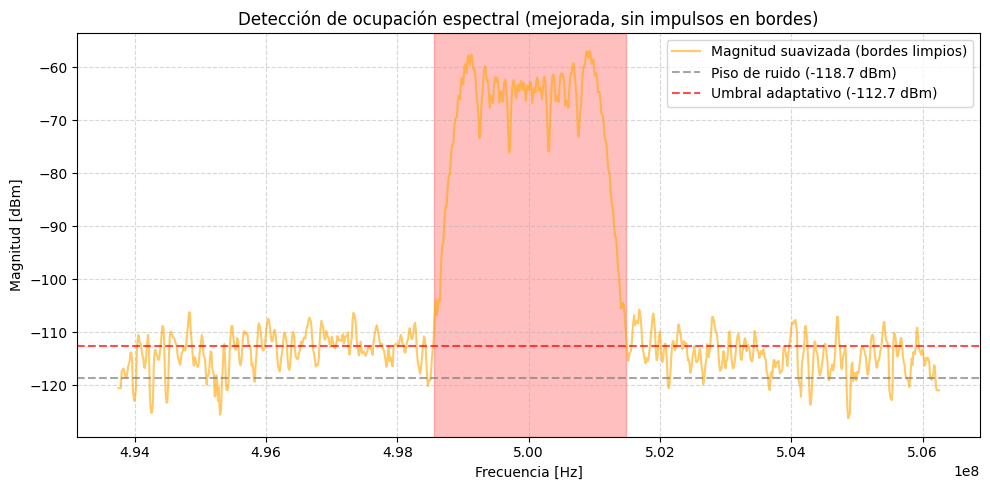


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -118.68 dBm
Desviación estándar del ruido: 2.40 dB
Umbral adaptativo: -112.69 dBm

Se detectaron 1 canales ocupados:
  Canal 1: 498.55 – 501.48 MHz


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/500GeneS.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/generador500M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1, ymax + abs(ymax - ymin)*1)

plt.tight_layout()
plt.show()
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 2   # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")

→ El bloque más parecido es el #1 con correlación r = 0.5639


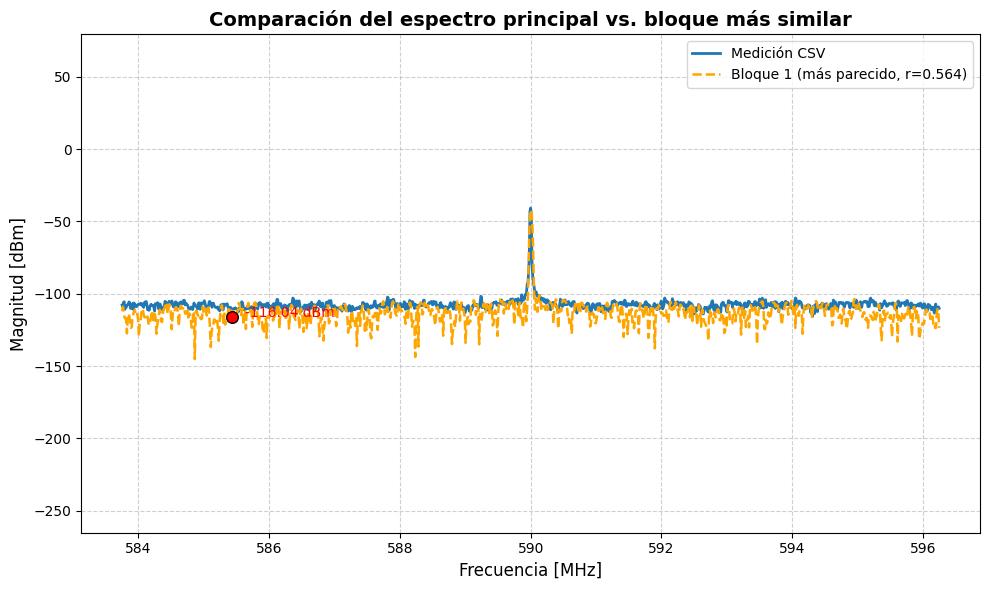

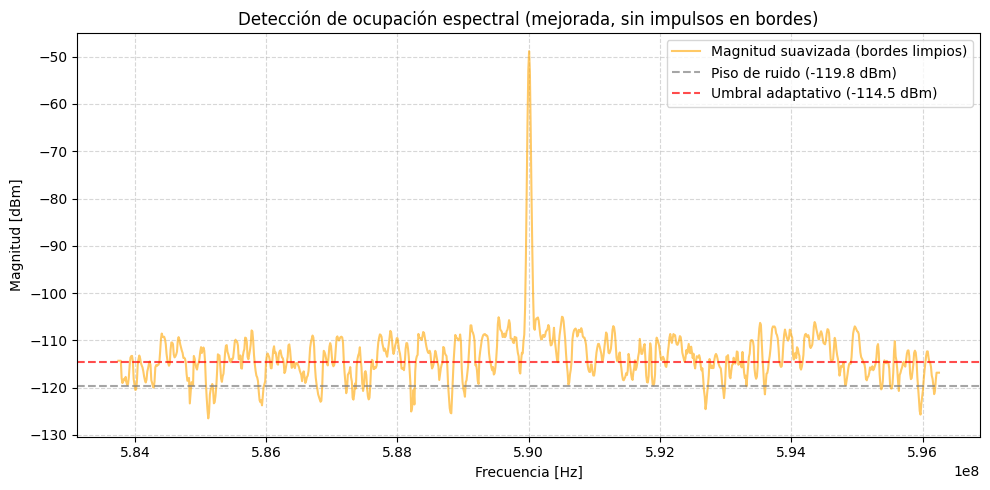


=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===
Piso de ruido estimado: -119.77 dBm
Desviación estándar del ruido: 2.09 dB
Umbral adaptativo: -114.55 dBm

No se detectaron canales ocupados.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

# === ARCHIVOS ===
archivo_csv = "/content/590eneS.csv"      # CSV con columnas frecuencia y magnitud
archivo_txt = "/content/generador590M.csv"      # Archivo con los 1024 datos (texto)

# ============================================================
# === 1. LEER EL ARCHIVO CSV DE FRECUENCIA Y MAGNITUD ========
# ============================================================
df = pd.read_csv(archivo_csv, header=None)
start_idx = df.index[df.iloc[:, 0].astype(str).str.contains("Frequency", na=False)].tolist()[0] + 1

# Tomar solo las dos primeras columnas (frecuencia y magnitud)
datos = df.iloc[start_idx:, [0, 1]].dropna()
datos.columns = ["Frecuencia [Hz]", "Magnitud [dBm]"]

# Convertir a numérico
datos["Frecuencia [Hz]"] = pd.to_numeric(datos["Frecuencia [Hz]"], errors="coerce")
datos["Magnitud [dBm]"] = pd.to_numeric(datos["Magnitud [dBm]"], errors="coerce")
datos = datos.dropna()

# Normalizar para comparación (solo magnitud)
mag_ref = datos["Magnitud [dBm]"].to_numpy()
mag_ref = (mag_ref - np.mean(mag_ref)) / np.std(mag_ref)

# ============================================================
# === 2. LEER EL ARCHIVO CON 1024 DATOS (MUESTREO) ===========
# ============================================================
with open(archivo_txt, 'r', encoding='utf-8', errors='ignore') as f:
    lineas = [l.strip() for l in f if l.strip()]

# Extraer parámetros principales
freq_central = None
sample_rate = None
vector_len = None

for linea in lineas:
    if "Frequency" in linea:
        freq_central = float(linea.split(":")[1])
    elif "Sample Rate" in linea:
        sample_rate = float(linea.split(":")[1])
    elif "Vector Length" in linea:
        vector_len = int(linea.split(":")[1])

# Extraer los bloques numéricos
datos_txt = []
for linea in lineas:
    if re.match(r"^[-\d\.\s,]+$", linea):
        valores = re.split(r"[\s,]+", linea.strip())
        numeros = []
        for v in valores:
            try:
                if v.strip() not in ["", "-", "--"]:
                    numeros.append(float(v))
            except ValueError:
                continue
        if len(numeros) > 1:
            datos_txt.append(numeros)

# Crear eje de frecuencia
freqs = np.linspace(freq_central - sample_rate/2,
                    freq_central + sample_rate/2,
                    vector_len)

# ============================================================
# === 3. ENCONTRAR LA GRAFICA MÁS PARECIDA ===================
# ============================================================
from scipy.stats import pearsonr

mejor_idx = -1
mejor_corr = -2  # fuera del rango posible [-1, 1]

# Redimensionar referencia si es necesario
if len(mag_ref) != vector_len:
    mag_ref_resampled = np.interp(np.linspace(0, 1, vector_len),
                                  np.linspace(0, 1, len(mag_ref)), mag_ref)
else:
    mag_ref_resampled = mag_ref

for i, bloque in enumerate(datos_txt):
    bloque = np.array(bloque)
    if len(bloque) == vector_len:
        bloque_norm = (bloque - np.mean(bloque)) / np.std(bloque)
        corr, _ = pearsonr(mag_ref_resampled, bloque_norm)
        if corr > mejor_corr:
            mejor_corr = corr
            mejor_idx = i

print(f"→ El bloque más parecido es el #{mejor_idx+1} con correlación r = {mejor_corr:.4f}")

# ============================================================
# === 4. GRAFICAR AMBAS CURVAS ===============================
# ============================================================
plt.figure(figsize=(10, 6))

# Curva principal
plt.plot(datos["Frecuencia [Hz]"]/1e6, datos["Magnitud [dBm]"],
         color="#1f77b4", linewidth=2, label="Medición CSV")

# Punto mínimo
min_idx = datos["Magnitud [dBm]"].idxmin()
plt.scatter(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6,
            datos.loc[min_idx, "Magnitud [dBm]"],
            color="red", s=70, edgecolor='black', zorder=5)
plt.text(datos.loc[min_idx, "Frecuencia [Hz]"]/1e6 + 0.2,
         datos.loc[min_idx, "Magnitud [dBm]"],
         f"{datos.loc[min_idx, 'Magnitud [dBm]']:.2f} dBm",
         color="red", fontsize=10)

# Bloque más parecido
if mejor_idx >= 0:
    plt.plot(freqs/1e6, datos_txt[mejor_idx],
             linestyle='--', color='orange', linewidth=1.8,
             label=f"Bloque {mejor_idx+1} (más parecido, r={mejor_corr:.3f})")

# ============================================================
# === 5. FORMATO FINAL =======================================
# ============================================================
plt.title("Comparación del espectro principal vs. bloque más similar", fontsize=14, weight='bold')
plt.xlabel("Frecuencia [MHz]", fontsize=12)
plt.ylabel("Magnitud [dBm]", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()

# Ajustar rango Y (20% más amplio)
ymin, ymax = plt.ylim()
plt.ylim(ymin - abs(ymax - ymin)*1, ymax + abs(ymax - ymin)*1)

plt.tight_layout()
plt.show()
# ============================================================
# === DETECCIÓN DE OCUPACIÓN ESPECTRAL (MEJORADA + SIN IMPULSOS + ROBUSTA)
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# ---------- Preparar datos base (usa el bloque más parecido) ----------
frecuencia = freqs
magnitud = np.array(datos_txt[mejor_idx])

# ---------- Parámetros ajustables ----------
ventana_suavizado = 5
k_sigma = 2.5
min_ancho_MHz = 2
tolerancia_puntos = 3
porcentaje_ruido = 20
gap_permitido = 2   # NUEVO: tolerancia a pequeños valles dentro de un canal
# ------------------------------------------

# === 1. Suavizado sin introducir impulsos ===
magnitud_ext = np.pad(magnitud, (ventana_suavizado//2,), mode='reflect')
magnitud_suav = np.convolve(magnitud_ext, np.ones(ventana_suavizado)/ventana_suavizado, mode='valid')

# === 2. Eliminar impulsos residuales en los extremos (recorte) ===
margen = 3
magnitud_suav[:margen] = magnitud_suav[margen]
magnitud_suav[-margen:] = magnitud_suav[-margen-1]

# === 3. Cálculo del piso de ruido ===
n_ruido = int(len(magnitud_suav) * porcentaje_ruido / 100)
indices_ruido = np.argsort(magnitud_suav)[:n_ruido]
piso_ruido = np.mean(magnitud_suav[indices_ruido])
sigma_ruido = np.std(magnitud_suav[indices_ruido])
umbral = piso_ruido + k_sigma * sigma_ruido

# === 4. Detección de canales ocupados (con tolerancia a huecos) ===
mask_ocupado = magnitud_suav > umbral

canales_ocupados = []
inicio = None
gap_count = 0

for i in range(len(mask_ocupado)):
    if mask_ocupado[i]:
        if inicio is None:
            inicio = i
        gap_count = 0  # reinicia el conteo de huecos dentro del canal
    else:
        if inicio is not None:
            gap_count += 1
            if gap_count > gap_permitido:  # si el hueco supera la tolerancia
                fin = i - gap_count + 1
                if fin - inicio >= tolerancia_puntos:
                    f_inicio = frecuencia[inicio]
                    f_fin = frecuencia[fin - 1]
                    ancho = abs(f_fin - f_inicio)
                    if ancho >= min_ancho_MHz * 1e6:
                        canales_ocupados.append((f_inicio, f_fin))
                inicio = None
                gap_count = 0

# Si el canal llega hasta el final
if inicio is not None:
    f_inicio = frecuencia[inicio]
    f_fin = frecuencia[-1]
    ancho = abs(f_fin - f_inicio)
    if ancho >= min_ancho_MHz * 1e6:
        canales_ocupados.append((f_inicio, f_fin))

# === 5. Visualización ===
plt.figure(figsize=(10, 5))
plt.plot(frecuencia, magnitud_suav, color='orange', alpha=0.6, label='Magnitud suavizada (bordes limpios)')
plt.axhline(piso_ruido, color='gray', linestyle='--', alpha=0.7, label=f'Piso de ruido ({piso_ruido:.1f} dBm)')
plt.axhline(umbral, color='red', linestyle='--', alpha=0.7, label=f'Umbral adaptativo ({umbral:.1f} dBm)')

for (f_ini, f_fin) in canales_ocupados:
    plt.axvspan(f_ini, f_fin, color='red', alpha=0.25)

plt.legend()
plt.title("Detección de ocupación espectral (mejorada, sin impulsos en bordes)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Magnitud [dBm]")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

# === 6. Reporte ===
print("\n=== RESULTADOS DE DETECCIÓN (MEJORADA Y LIMPIA) ===")
print(f"Piso de ruido estimado: {piso_ruido:.2f} dBm")
print(f"Desviación estándar del ruido: {sigma_ruido:.2f} dB")
print(f"Umbral adaptativo: {umbral:.2f} dBm")

if canales_ocupados:
    print(f"\nSe detectaron {len(canales_ocupados)} canales ocupados:")
    for i, (f1, f2) in enumerate(canales_ocupados, 1):
        print(f"  Canal {i}: {f1/1e6:.2f} – {f2/1e6:.2f} MHz")
else:
    print("\nNo se detectaron canales ocupados.")